# Calculate summary statistics for the variations

In [45]:
import cogsworth
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import gala.dynamics as gd
import os

In [46]:
import sys
sys.path.append("../src")
import plotting

In [47]:
import h5py as h5

In [48]:
%config InlineBackend.figure_format = 'retina'

pd.options.display.max_columns = 999

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

In [49]:
from importlib import reload
reload(plotting)

<module 'plotting' from '/mnt/home/twagg/supernova-feedback/notebooks/../src/plotting.py'>

In [51]:
pop_details = {
    "file_names": ["fiducial",
                   # binary physics
                   "ce-0.1", "ce-10.0", "qcritB-0.0", "qcritB-1000.0",
                   "beta-0.0", "beta-0.5", "beta-1.0",
                   "ccsn-20", "ecsn-265", "no-fallback",
                   # initial conditions
                   "singles",
                   "imf-1.9", "imf-2.7",
                   "porb-0", "porb-minus1", 'porb-max-3', "q-plus1", "q-minus1",
                   # metallicity
                   "Z-0.5", "Z-0.2", "Z-0.1", "Z-0.05",
                   # galaxy parameters
                   "v-disp-0.5", "v-disp-5", "r442-Zx2"],
    "labels": np.array(["Fiducial", 
                        # binary physics
                        r"$\alpha_{\rm CE} = 0.1$", r"$\alpha_{\rm CE} = 10.0$",
                        "Case B\nUnstable", "Case B\nStable",
                        r"$\beta = 0.0$", r"$\beta = 0.5$",
                        r"$\beta = 1.0$",
                        r"$\sigma_{\rm CC} = $" + "\n" + r"$20 \, {\rm km/s}$", r"$\sigma_{\rm low} = $" + "\n" + r"$265 \, {\rm km/s}$", "No fallback",
                        # initial conditions
                        r"$f_{\rm bin} = 0.0$",
                        r"$\alpha_{\rm IMF} = -1.9$", r"$\alpha_{\rm IMF} = -2.7$",
                        r"$\pi = 0$", r"$\pi = -1$", r"$P_{\rm 0, max} = 10^{3} \, {\rm d}$", r"$\kappa = 1$", r"$\kappa = -1$",
                        # metallicity
                        r"$\bar{Z} = 0.5 \, \bar{Z}_{\rm m11h}$", r"$\bar{Z} = 0.2 \, \bar{Z}_{\rm m11h}$",
                        r"$\bar{Z} = 0.1 \, \bar{Z}_{\rm m11h}$", r"$\bar{Z} = 0.05 \, \bar{Z}_{\rm m11h}$",
                        # galaxy parameters
                        r"$v_{\rm disp} = 0.5 \, {\rm km/s}$", r"$v_{\rm disp} = 5 \, {\rm km/s}$", "ChaNGa (r442)"]),
    "table_labels": ['Fiducial',
                     # binary physics
                     'Common envelope, $\\alpha_{\\rm CE} = 0.1$', 'Common envelope, $\\alpha_{\\rm CE} = 10.0$',
                     'Case B Unstable', 'Case B Stable', 'Mass transfer efficiency, $\\beta = 0.0$',
                     'Mass transfer efficiency, $\\beta = 0.5$', 'Mass transfer efficiency, $\\beta = 1.0$',
                     'Supernova kicks, $\\sigma_{\\rm CC} = 20 \\, {\\rm km/s}$',
                     'Supernova kicks, $\\sigma_{\\rm low} = 265 \\, {\\rm km/s}$', 'Supernova kicks, No fallback',
                     # initial conditions
                     'Singles, $f_{\\rm bin} = 0.0$', 'Initial mass function slope, $\\alpha_{\\rm IMF} = -1.9$',
                     'Initial mass function slope, $\\alpha_{\\rm IMF} = -2.7$',
                     'Orbital period slope, $\\pi = 0$', 'Orbital period slope, $\\pi = -1$',
                     'Initial upper orbital period limit, $P_{\rm 0, max} = 10^{3} \, {\rm d}$',
                     'Mass ratio slope, $\\kappa = 1$', 'Mass ratio slope, $\\kappa = -1$',
                     # metallicity
                     'Metallicity, $\\bar{Z} = 0.5 \\, \\bar{Z}_{\\rm m11h}$',
                     'Metallicity, $\\bar{Z} = 0.2 \\, \\bar{Z}_{\\rm m11h}$',
                     'Metallicity, $\\bar{Z} = 0.1 \\, \\bar{Z}_{\\rm m11h}$',
                     'Metallicity, $\\bar{Z} = 0.05 \\, \\bar{Z}_{\\rm m11h}$',
                     # galaxy parameters
                     'Velocity dispersion, $v_{\\rm disp} = 0.5 \ {\\rm km/s}$', 'Velocity dispersion, $v_{\\rm disp} = 5 \ {\\rm km/s}$',
                     'ChaNGa (r442)'],
}

# Generate statistics

In [52]:
Nv = len(pop_details["file_names"])
time_percentiles = np.zeros((Nv, 4, 5))
dist_percentiles = np.zeros((Nv, 4, 5))
totals = np.zeros((Nv, 4))
tails = np.zeros((Nv, 3))

In [53]:
p = None

In [54]:
bins = np.linspace(0, 3.5, 201)
bin_centres, bin_widths = plotting.get_centres_widths(bins)
max_times = np.concatenate((np.arange(4, 50, 0.5), np.arange(50, 200 + 5, 5)))
with h5.File("../data/plotly-feedback-sn-dists-by-time.h5", "w") as f:
    f.create_dataset("bin_centres", data=bin_centres)
    f.create_dataset("bin_widths", data=bin_widths)
    f.create_dataset("max_times", data=max_times)

In [55]:
%%time
for i, file in enumerate(pop_details["file_names"]):
    # if i != 24:
    #     continue
    del p
    print(file)
    p = cogsworth.pop.load(f"/mnt/home/twagg/ceph/pops/feedback-variations/{file}.h5", parts=[])
    plotting.set_sn_subpop_masks(p);

    f = np.load(f"/mnt/home/twagg/ceph/pops/feedback-variations/sn_positions-{file}.npz")
    p.primary_sn_distances, p.secondary_sn_distances = f["arr_0"] * u.kpc, f["arr_1"] * u.kpc

    times = plotting.get_data_and_weights(p, "time", [1])[0]
    all_times = np.concatenate(times)
    print(len(all_times))
    ts = [times[2], times[1], times[0], all_times]
    
    dists = plotting.get_data_and_weights(p, "distance", [1])[0]
    all_dists = np.concatenate(dists)
    ds = [dists[2], dists[1], dists[0], all_dists]

    time_percentiles[i] = np.array([np.percentile(t, [2.5, 25, 50, 75, 97.5]) if len(t) > 0 else [-1, -1, -1, -1, -1] for t in ts])
    dist_percentiles[i] = np.array([np.percentile(d, [2.5, 25, 50, 75, 97.5]) if len(d) > 0 else [-1, -1, -1, -1, -1] for d in ds])
    totals[i] = np.array([len(t) for t in ts])
    tails[i] = np.array([(all_times > 44).sum() / len(all_times), (all_dists > 100).sum() / len(all_dists), (all_dists > 500).sum() / len(all_dists)])


    plotly_histograms = np.zeros((4, len(max_times), len(bin_centres)))

    for j in range(len(dists)):
        for k in range(len(max_times)):
            plotly_histograms[j][k] = np.histogram(np.log10(dists[j])[times[j] < max_times[k]], bins=bins)[0]

    with h5.File("../data/plotly-feedback-sn-dists-by-time.h5", "a") as f:
        f.create_dataset(file, data=plotly_histograms)

fiducial
16426 283504 182812 378076
860818
ce-0.1
16335 253064 172596 444597
886592
ce-10.0
16358 314403 231198 179955
741914
qcritB-0.0
16414 129330 56588 623599
825931
qcritB-1000.0
16340 469945 298604 218076
1002965
beta-0.0
16402 279715 166714 223503
686334
beta-0.5
16395 286212 190077 284093
776777
beta-1.0
16419 283806 187114 399829
887168
ccsn-20
13822 288396 86403 374726
763347
ecsn-265
16369 283100 189584 378629
867682
no-fallback
17402 283257 185494 377754
863907
singles
779102 0 0 0
779102
imf-1.9
33786 515196 357775 518597
1425354
imf-2.7
6659 122562 73059 213284
415564
porb-0
27248 341815 204567 243606
817236
porb-minus1
9587 226823 155653 515122
907185
porb-max-3
16582 283886 183332 376709
860509
q-plus1
25034 278569 205494 369805
878902
q-minus1
8211 273909 136733 412481
831334
Z-0.5
14970 308041 196284 387789
907084
Z-0.2
10745 337789 212648 391381
952563
Z-0.1
4340 354694 225390 407448
991872
Z-0.05
10001 379956 234221 399962
1024140
v-disp-0.5
16426 283504 182812 3780

In [56]:
star_forming_mass = []
for file in pop_details["file_names"]:
    with h5.File(f"/mnt/home/twagg/ceph/pops/feedback-variations/{file}.h5", "r") as f:
        star_forming_mass.append(f["numeric_params"][...][-3])

In [57]:
stat_table = {
    "file": pop_details["file_names"],
    "plot_label": pop_details["labels"],
    "table_label": pop_details["table_labels"], 
    "f_late": tails[:, 0],
    "f_far": tails[:, 1],
    "f_distant": tails[:, 2],
    "star_forming_mass": star_forming_mass
}
for i, sub in enumerate(["_p", "_s", "_m", ""]):
    stat_table[f"total{sub}"] = totals[:, i]
    for j, perc in enumerate(["2.5", "25", "50", "75", "97.5"]):
        stat_table[f"time{sub}_{perc}"] = time_percentiles[:, i, j]
        stat_table[f"distance{sub}_{perc}"] = dist_percentiles[:, i, j]
stats = pd.DataFrame(stat_table)

In [66]:
stats.to_hdf("../data/variation_stats.h5", key="df")

### Or just read them

In [58]:
with h5.File("../data/plotly_stats.h5", "w") as f:
    for k in stat_table:
        print(k, stat_table[k])
        f.create_dataset(k, data=stat_table[k] if isinstance(stat_table[k], list) else stat_table[k].tolist())

file ['fiducial', 'ce-0.1', 'ce-10.0', 'qcritB-0.0', 'qcritB-1000.0', 'beta-0.0', 'beta-0.5', 'beta-1.0', 'ccsn-20', 'ecsn-265', 'no-fallback', 'singles', 'imf-1.9', 'imf-2.7', 'porb-0', 'porb-minus1', 'porb-max-3', 'q-plus1', 'q-minus1', 'Z-0.5', 'Z-0.2', 'Z-0.1', 'Z-0.05', 'v-disp-0.5', 'v-disp-5', 'r442-Zx2']
plot_label ['Fiducial' '$\\alpha_{\\rm CE} = 0.1$' '$\\alpha_{\\rm CE} = 10.0$'
 'Case B\nUnstable' 'Case B\nStable' '$\\beta = 0.0$' '$\\beta = 0.5$'
 '$\\beta = 1.0$' '$\\sigma_{\\rm CC} = $\n$20 \\, {\\rm km/s}$'
 '$\\sigma_{\\rm low} = $\n$265 \\, {\\rm km/s}$' 'No fallback'
 '$f_{\\rm bin} = 0.0$' '$\\alpha_{\\rm IMF} = -1.9$'
 '$\\alpha_{\\rm IMF} = -2.7$' '$\\pi = 0$' '$\\pi = -1$'
 '$P_{\\rm 0, max} = 10^{3} \\, {\\rm d}$' '$\\kappa = 1$'
 '$\\kappa = -1$' '$\\bar{Z} = 0.5 \\, \\bar{Z}_{\\rm m11h}$'
 '$\\bar{Z} = 0.2 \\, \\bar{Z}_{\\rm m11h}$'
 '$\\bar{Z} = 0.1 \\, \\bar{Z}_{\\rm m11h}$'
 '$\\bar{Z} = 0.05 \\, \\bar{Z}_{\\rm m11h}$'
 '$v_{\\rm disp} = 0.5 \\, {\\rm km/s

In [44]:
stats

,file,plot_label,table_label,f_late,f_far,f_distant,star_forming_mass,total_p,time_p_2.5,distance_p_2.5,time_p_25,distance_p_25,time_p_50,distance_p_50,time_p_75,distance_p_75,time_p_97.5,distance_p_97.5,total_s,time_s_2.5,distance_s_2.5,time_s_25,distance_s_25,time_s_50,distance_s_50,time_s_75,distance_s_75,time_s_97.5,distance_s_97.5,total_m,time_m_2.5,distance_m_2.5,time_m_25,distance_m_25,time_m_50,distance_m_50,time_m_75,distance_m_75,time_m_97.5,distance_m_97.5,total,time_2.5,distance_2.5,time_25,distance_25,time_50,distance_50,time_75,distance_75,time_97.5,distance_97.5
0,fiducial,Fiducial,Fiducial,0.254069,0.132199,0.009332,7.306188e+07,283504.0,4.053242,3.502895,7.468106,9.919323,13.043853,17.807325,21.384181,31.310296,40.655599,72.125650,182812.0,5.151960,6.841026,9.697720,27.237875,15.297688,52.768414,23.522331,101.631305,43.745391,770.594393,378076.0,5.957146,6.432900,25.845459,25.601578,50.377883,48.659181,84.558897,82.417285,171.542887,206.213781,860818.0,4.404488,4.578735,10.756637,16.351807,21.366180,34.650249,44.612107,66.823336,143.486694,242.087726
1,ce-0.1,$\alpha_{\rm CE} = 0.1$,"Common envelope, $\alpha_{\rm CE} = 0.1$",0.250286,0.122235,0.005173,7.306188e+07,253064.0,4.027241,3.401192,7.129388,9.465924,12.009699,16.680556,20.077405,29.446814,40.560457,71.129623,172596.0,5.172216,6.769884,9.556664,26.480812,14.814542,50.246493,22.315290,92.693955,42.347575,509.990376,444597.0,5.941967,6.476404,23.444546,24.979538,43.156537,45.769330,80.365067,77.206851,155.969360,199.158520,886592.0,4.425175,4.636551,11.048743,16.665453,22.174933,34.779410,44.033812,65.269220,139.898302,208.709941
2,ce-10.0,$\alpha_{\rm CE} = 10.0$,"Common envelope, $\alpha_{\rm CE} = 10.0$",0.137768,0.110262,0.010492,7.306188e+07,314403.0,4.081118,3.575312,7.684900,10.192530,13.616502,18.560541,22.377046,32.930256,43.537822,79.098089,231198.0,5.289106,7.445896,10.470897,28.867624,17.644796,53.147908,28.849019,96.635681,62.013424,588.865195,179955.0,5.183601,5.392819,15.815931,19.359698,35.861043,38.658778,71.032197,69.903783,160.646380,184.252222,741914.0,4.313651,4.350350,9.521511,14.656198,17.533196,30.297878,31.461078,58.835044,105.641856,250.512185
3,qcritB-0.0,Case B\nUnstable,Case B Unstable,0.310963,0.115850,0.003878,7.306188e+07,129330.0,4.230058,3.979327,9.687122,12.474067,18.188341,23.706558,29.111881,40.621758,42.640704,83.324027,56588.0,4.718421,5.029782,10.752059,20.548378,19.595071,51.187782,31.088284,125.000687,44.680811,839.928301,623599.0,4.384142,4.643875,13.555907,16.982562,33.509817,36.255744,67.164030,67.766604,150.180972,182.006570,825931.0,4.299622,4.446184,12.103746,15.821772,27.087177,33.597308,54.163913,63.761921,142.486991,197.838538
4,qcritB-1000.0,Case B\nStable,Case B Stable,0.307249,0.209898,0.031403,7.306188e+07,469945.0,4.250887,4.106496,10.257244,13.257624,21.554947,27.191692,48.131900,52.966588,205.748585,199.102214,298604.0,5.557670,8.508304,12.752832,38.283706,23.591744,84.301538,46.644536,236.747230,136.864467,818.235502,218076.0,5.572591,5.865315,19.787841,22.211679,42.403234,43.637172,75.789457,75.860266,150.469249,187.956928,1002965.0,4.518196,4.855243,12.101438,18.532221,25.352244,40.432799,57.980474,85.139108,185.503376,556.749056
5,beta-0.0,$\beta = 0.0$,"Mass transfer efficiency, $\beta = 0.0$",0.122761,0.130013,0.019523,7.306188e+07,279715.0,4.055867,3.499510,7.469375,9.912414,13.016377,17.786568,21.318411,31.274480,40.724682,72.170337,166714.0,4.425984,5.075734,8.773750,25.579434,15.517346,69.988734,26.012331,177.427891,42.818867,1000.883295,223503.0,4.943756,5.201046,14.839435,18.421149,31.465424,36.471732,56.665911,64.367387,117.411665,158.531627,686334.0,4.214120,4.098862,9.029303,13.397480,17.013082,28.251349,31.110236,59.232446,92.202664,412.816807
6,beta-0.5,$\beta = 0.5$,"Mass transfer efficiency, $\beta = 0.5$",0.178840,0.136815,0.015506,7.306188e+07,286212.0,4.059735,3.517893,7.511882,9.961227,13.112334,17.894462,21.443488,31.406022,40.627850,72.078692,190077.0,4.936866,6.603965,9.8

In [38]:
stats_file = pd.read_hdf("../data/variation_stats.h5", key="df")

# Totals plot

In [69]:
plot_order = [
    "fiducial",

    "ce-0.1", "ce-10.0", "qcritB-0.0", "qcritB-1000.0",
    "beta-0.0", "beta-0.5", "beta-1.0",
    "ccsn-20", "ecsn-265", "no-fallback",
    
    "porb-0", "porb-minus1", "q-plus1", "q-minus1",
    "imf-1.9", "imf-2.7",
    
    "Z-0.5", "Z-0.2", "Z-0.1", "Z-0.05",
    
    "r442-Zx2", "v-disp-0.5", "v-disp-5",
]

def get_inds_y_vals(plot_order, gaps=[1, 11, 17, 21], gap_size=0.5):
    plot_inds = [list(stats["file"].values).index(o) for o in plot_order]
    y_vals = np.array([v for v in np.arange(len(plot_inds))], dtype="float")
    
    gap_size = 0.5
    for gap in gaps:
        y_vals[gap:] += gap_size
    return plot_inds, y_vals

plot_inds, y_vals = get_inds_y_vals(plot_order)

In [72]:
stats.loc[[0, 24]]

,file,plot_label,table_label,f_late,f_far,f_distant,star_forming_mass,total_p,time_p_2.5,distance_p_2.5,time_p_25,distance_p_25,time_p_50,distance_p_50,time_p_75,distance_p_75,time_p_97.5,distance_p_97.5,total_s,time_s_2.5,distance_s_2.5,time_s_25,distance_s_25,time_s_50,distance_s_50,time_s_75,distance_s_75,time_s_97.5,distance_s_97.5,total_m,time_m_2.5,distance_m_2.5,time_m_25,distance_m_25,time_m_50,distance_m_50,time_m_75,distance_m_75,time_m_97.5,distance_m_97.5,total,time_2.5,distance_2.5,time_25,distance_25,time_50,distance_50,time_75,distance_75,time_97.5,distance_97.5
0,fiducial,Fiducial,Fiducial,0.254069,0.132199,0.009332,7.306188e+07,283504.0,4.053242,3.502895,7.468106,9.919323,13.043853,17.807325,21.384181,31.310296,40.655599,72.125650,182812.0,5.151960,6.841026,9.697720,27.237875,15.297688,52.768414,23.522331,101.631305,43.745391,770.594393,378076.0,5.957146,6.432900,25.845459,25.601578,50.377883,48.659181,84.558897,82.417285,171.542887,206.213781,860818.0,4.404488,4.578735,10.756637,16.351807,21.366180,34.650249,44.612107,66.823336,143.486694,242.087726
24,r442-Zx2,ChaNGa (r442),ChaNGa (r442),0.270458,0.090468,0.005876,4.726160e+07,93813.0,4.141159,3.733711,8.586210,11.162439,15.788101,20.585131,26.766850,35.366285,41.820774,77.421366,46611.0,4.693692,5.135813,9.869042,19.338552,17.170180,44.160510,28.317382,107.993311,43.589650,1053.874127,347268.0,4.465286,4.534674,13.218664,15.415587,31.440548,30.476052,63.570879,56.483491,154.504944,172.711116,498444.0,4.311412,4.288130,11.190415,14.277752,23.925273,28.403922,47.425820,53.366673,141.069347,197.603476


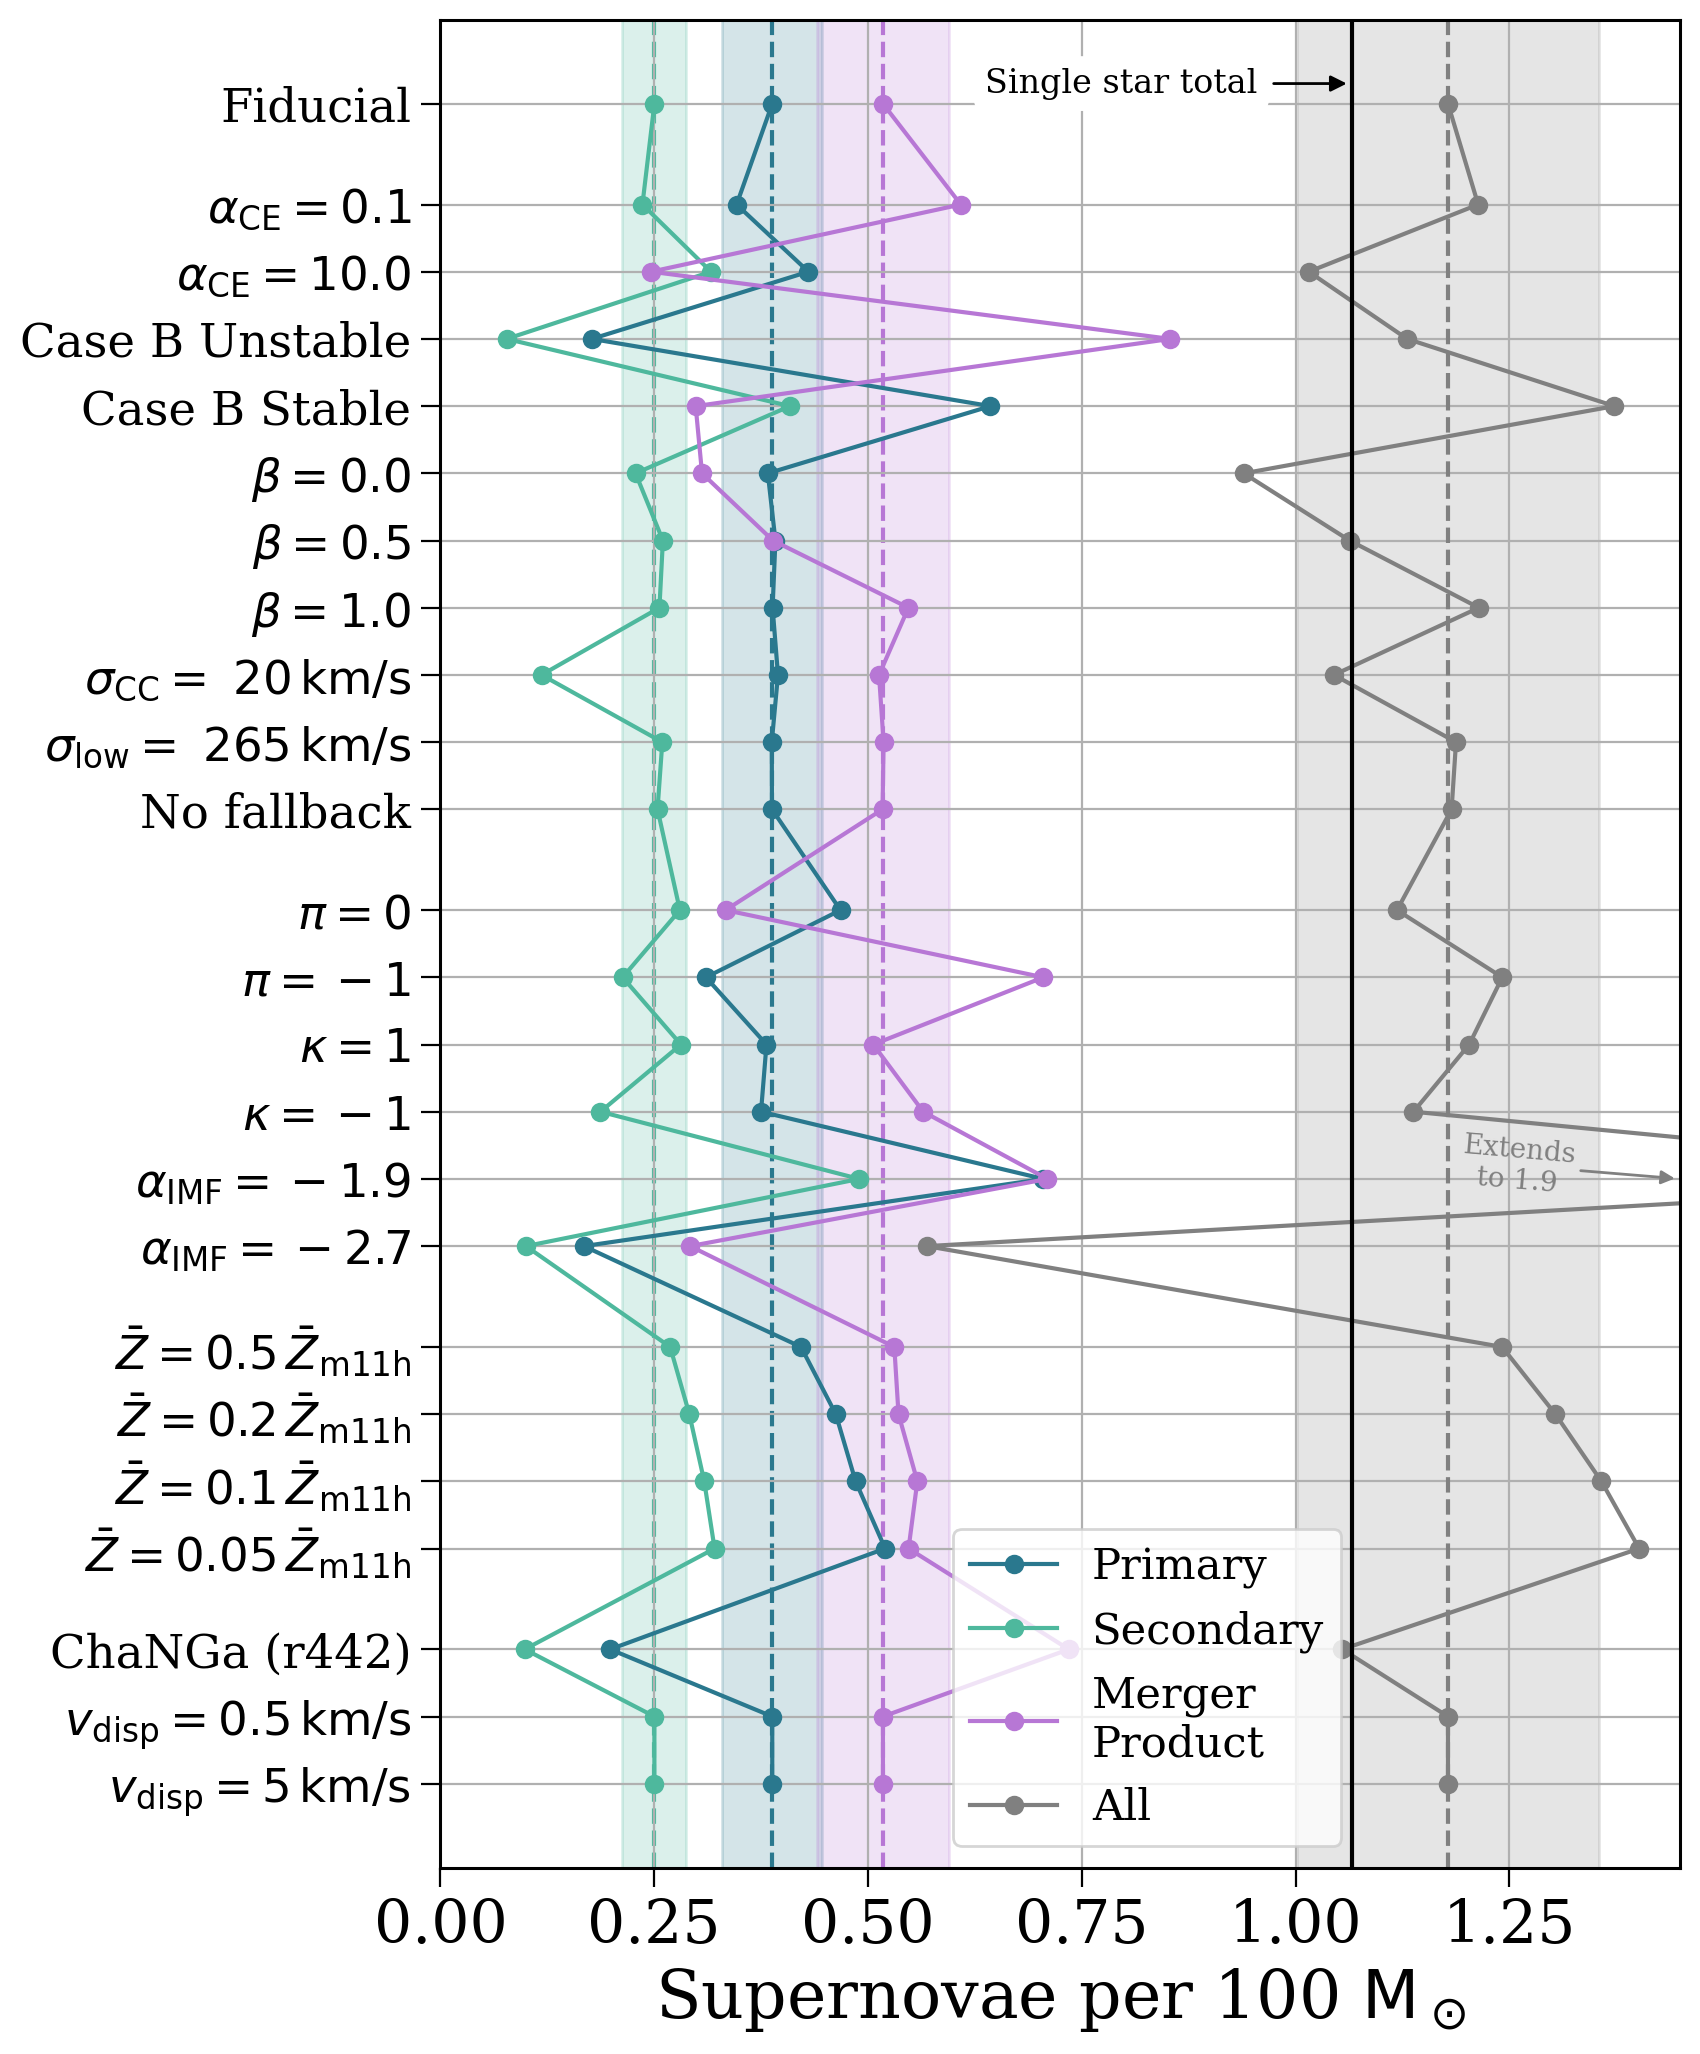

In [70]:
fig, ax = plt.subplots(figsize=(8, 12))

fig.subplots_adjust(wspace=0.0)

for sub, c, l in zip(["p", "s", "m"], list(reversed(plotting.colours[:-1])), list(reversed(plotting.labels[:-1]))):
    if l == "Merger Product":
        l = "Merger\nProduct"
    ax.plot(stats[f"total_{sub}"].values[plot_inds] / stats["star_forming_mass"].values[plot_inds] * 100,
            y_vals, color=c, marker="o", label=l)

    ref = stats[f"total_{sub}"].values[0] / stats["star_forming_mass"].iloc[0] * 100
    ax.axvline(ref, color=c, linestyle="--", zorder=-1)
    ax.axvspan(ref * 0.85, ref * 1.15, color=c, alpha=0.2, zorder=-2)

ax.plot(stats[f"total"].values[plot_inds] / stats["star_forming_mass"].values[plot_inds] * 100,
        y_vals, color="grey", marker="o", label="All")

ref = stats[f"total"].iloc[0] / stats["star_forming_mass"].iloc[0] * 100
ax.axvline(ref, color="grey", linestyle="--")
ax.axvspan(ref * 0.85, ref * 1.15, color="grey", alpha=0.2, zorder=-2)

ref = stats[f"total"].loc[11] / stats["star_forming_mass"].loc[11] * 100
ax.axvline(ref, color="black", linestyle="-")
ax.annotate("Single star total", xy=(ref, -0.3), xytext=(ref - 0.27, -0.3), fontsize=0.5*fs, ha="center", va="center",
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='white'),
            arrowprops=dict(arrowstyle="-|>", color="black"))

ax.set(yticks=y_vals,
       xlim=(0.0, 1.45),
       xlabel=r"Supernovae per 100 ${\rm M_\odot}$")
ax.set_yticklabels(stats["plot_label"].str.replace("\n", " ").values[plot_inds], fontsize=0.7*fs)

ax.annotate("Extends\nto 1.9", xy=(1.45, y_vals[15] - 0), xytext=(1.26, y_vals[15] - 0.2), color="grey", ha="center", va="center",
            bbox=dict(boxstyle="round", color="grey", alpha=0.0, pad=0.03),
            arrowprops=dict(arrowstyle="-|>", color="grey"), rotation=-5)

ax.legend(fontsize=0.65*fs, loc="lower center", bbox_to_anchor=(0.57, 0.0))

# for l, c, loc in zip(["Primary", "Secondary", "Merger\nProduct", "Total"],
#                      list(reversed(plotting.colours[:-1])) + ["grey"],
#                      [(stats["total_p"].values[0], -0.8), (stats["total_s"].values[0], -0.2), (stats["total_m"].values[0], -1.35), (stats["total"].values[0], -0.9)]):
#     loc = (loc[0] / stats["star_forming_mass"].iloc[0] * 100, loc[1])
#     ax.annotate(l, xy=loc, ha="center", va="bottom", fontsize=0.5*fs if l != "Total" else 0.8*fs, color=c, rotation=0, bbox=dict(boxstyle="round", fc="white", ec="white", pad=0.1))
# ax.set_ylim((-2.5, y_vals[-1] + 0.5))

ax.grid()
ax.invert_yaxis()

# plt.savefig("../plots/trends_totals.pdf", format="pdf", bbox_inches="tight")

plt.show()

# Tails plot

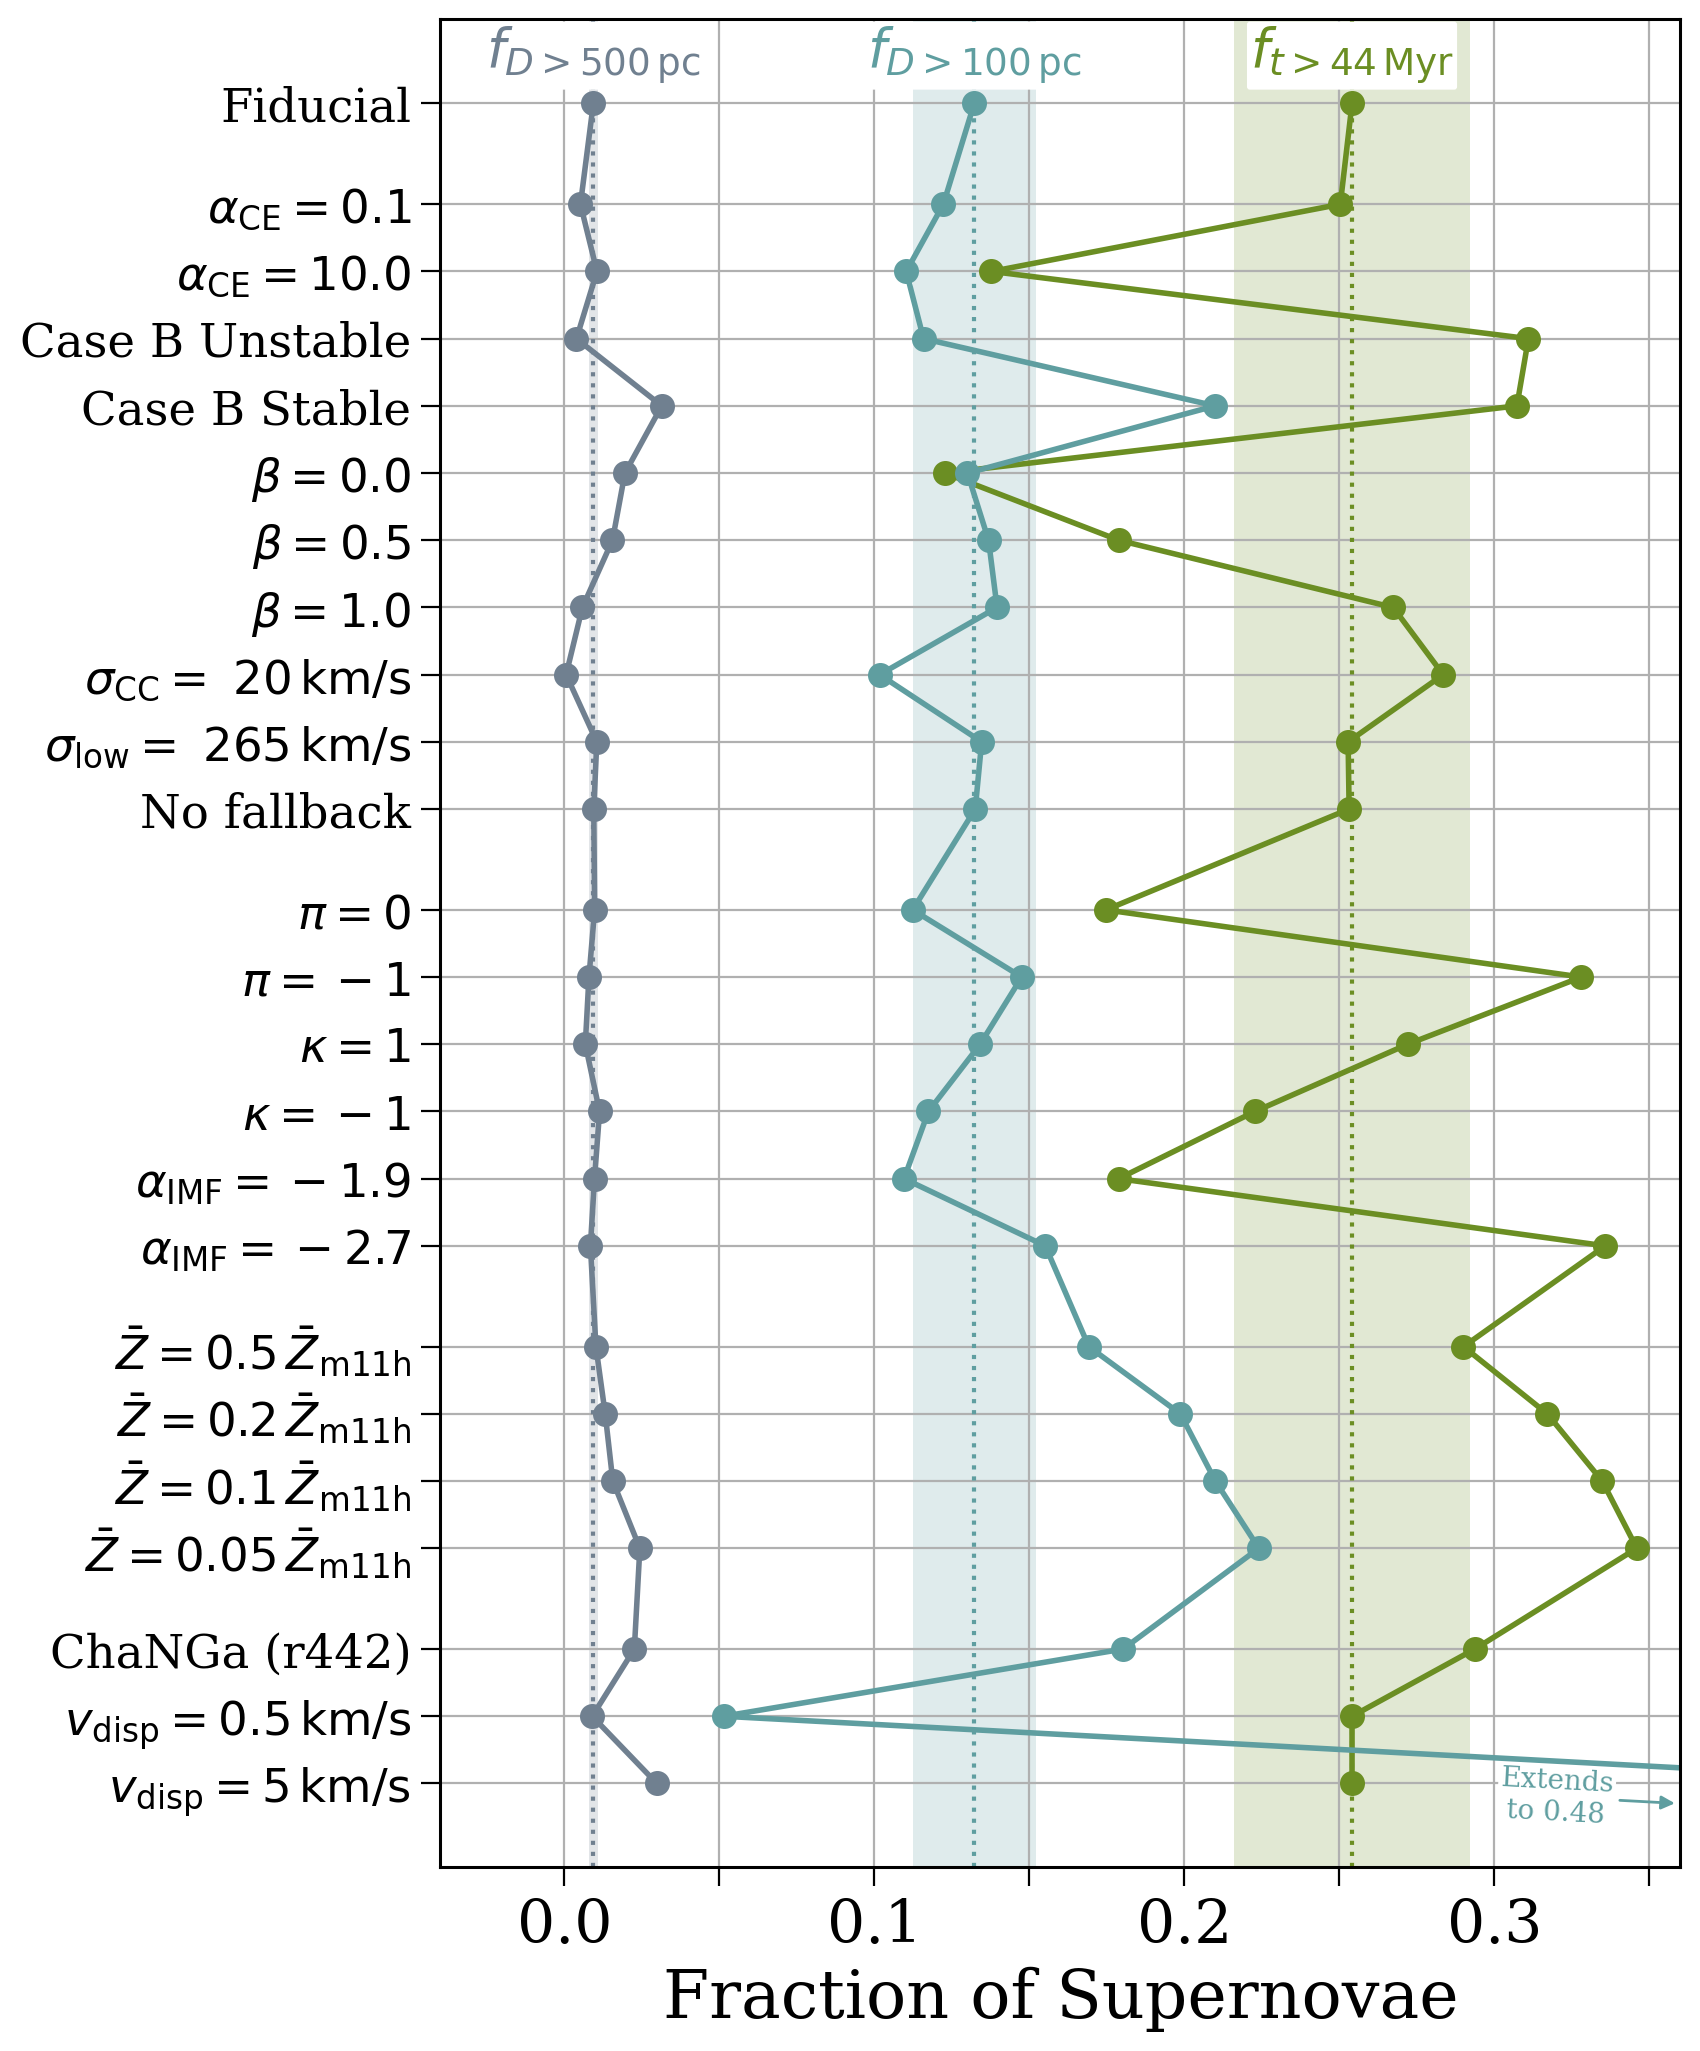

In [43]:
fig, ax = plt.subplots(figsize=(8, 12))

stat_cs = ["olivedrab", "cadetblue", "slategrey"]
stat_ls = [r"$f_{t > 44 \, {\rm Myr}}$", r"$f_{D > 100 \, {\rm pc}}$", r"$f_{D > 500 \, {\rm pc}}$"]

span = 0.15

for stat, c, l in zip([stats["f_late"].values, stats["f_far"].values, stats["f_distant"].values], stat_cs, stat_ls):
    ax.plot([stat[i] for i in plot_inds], y_vals, marker="o", color=c, label=l, markersize=8, lw=2)
    ax.axvline(stat[0], color=c, linestyle="dotted")
    ax.axvspan(stat[0] * (1 - span), stat[0] * (1 + span), color=c, alpha=0.2, zorder=-1, lw=0)

ax.set(xlim=(-0.04, 0.36), xlabel="Fraction of Supernovae")
ax.set_yticks(y_vals)
ax.set_yticklabels([stats["plot_label"].values[i].replace("\n", " ") for i in plot_inds], fontsize=0.7*fs)

ax.set_xticks([0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35])
ax.set_xticklabels([0.0, "", 0.1, "", 0.2, "", 0.3, ""])

for l, c, loc in zip(stat_ls, stat_cs,
                  [(stats["f_late"].values[0], -0.25), (stats["f_far"].values[0], -0.25), (stats["f_distant"].values[0], -0.25)]):
    ax.annotate(l, xy=loc, ha="center", va="bottom", fontsize=0.8*fs, bbox=dict(boxstyle="round", fc="white", ec="white", pad=0.03), color=c)

ax.grid()

ax.invert_yaxis()

ax.annotate("Extends\nto 0.48", xy=(0.36, y_vals[-1] + 0.3), xytext=(0.32, y_vals[-1] + 0.2), color=stat_cs[1], ha="center", va="center",
            bbox=dict(boxstyle="round", fc="white", ec="white", pad=0.03),
            arrowprops=dict(arrowstyle="-|>", color=stat_cs[1]), rotation=-3)

plt.savefig("../plots/trends_tails.pdf", format="pdf", bbox_inches="tight")

plt.show()

# Medians plot

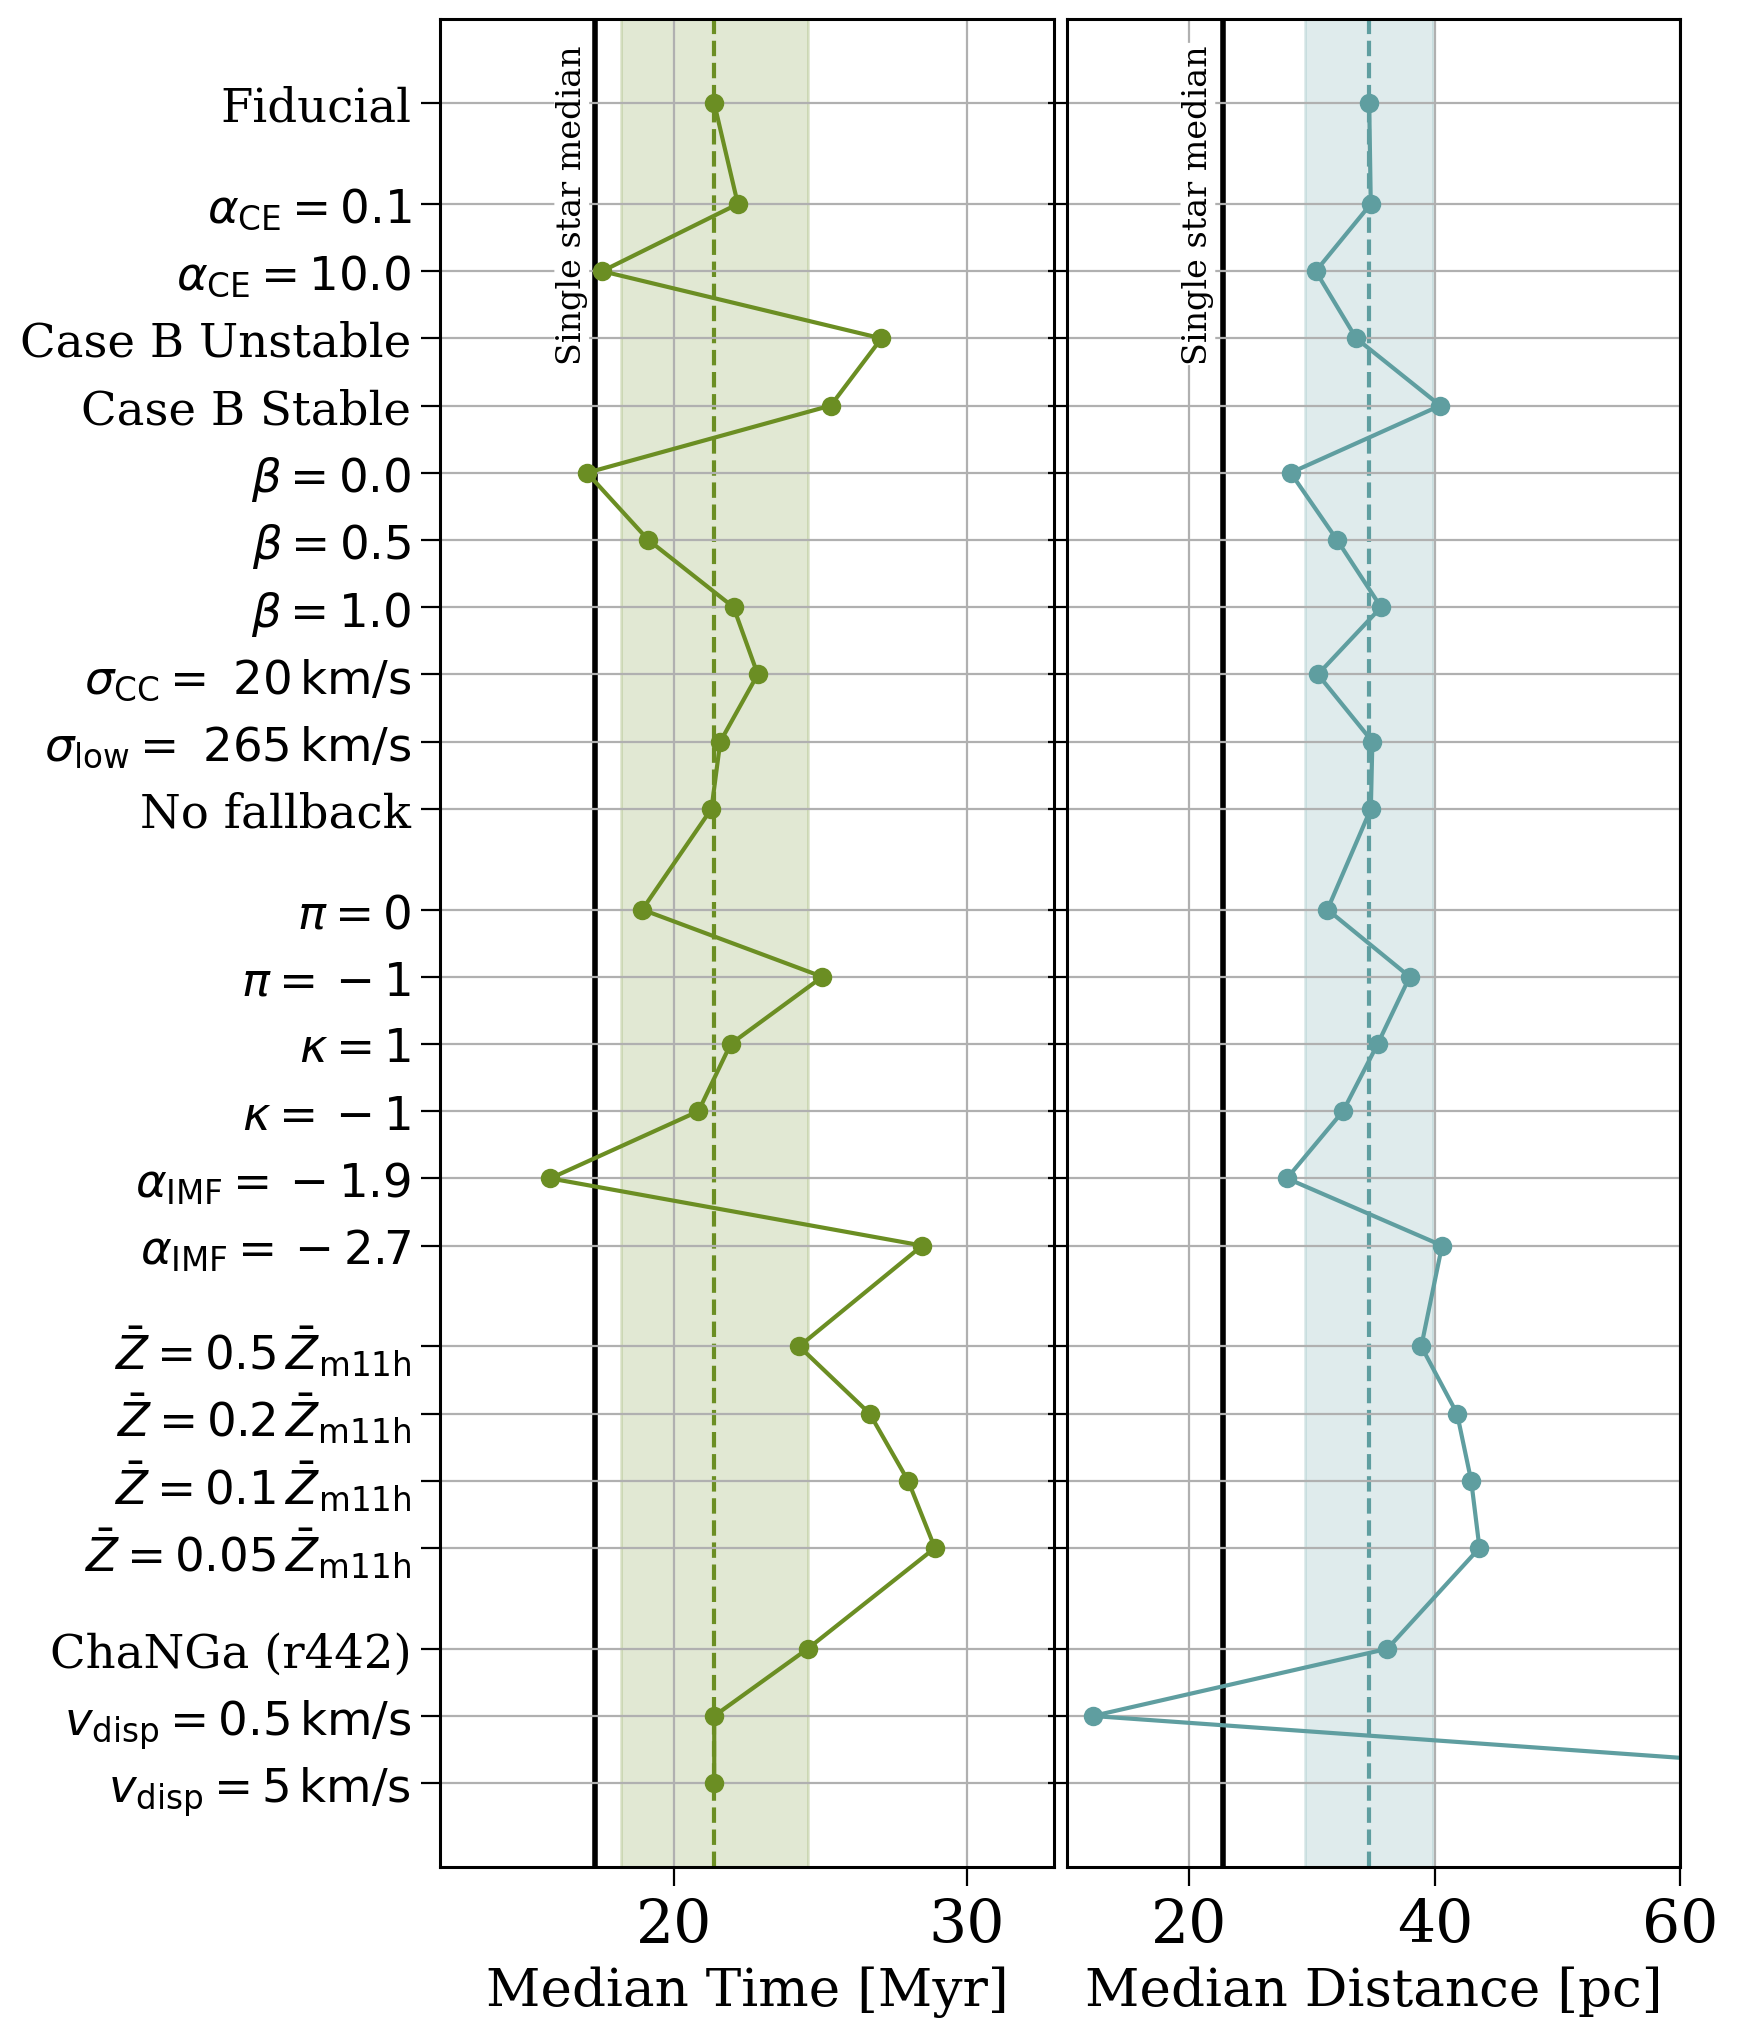

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(8, 12), sharey=True)

fig.subplots_adjust(wspace=0.02)

for ax, var, c, l in zip(axes, ["time", "distance"], [stat_cs[0], stat_cs[1]], ["", ""]):
    ax.plot(stats[f"{var}_50"].values[plot_inds],
            y_vals, color=c, marker="o", label=l)
    # ax.fill_betweenx(y_vals, stats[f"{var}_25"].values[plot_inds], stats[f"{var}_75"].values[plot_inds],
    #                  color=c, alpha=0.2, lw=0.0, zorder=-1)

    ref = stats[f"{var}_50"].values[0]
    ax.axvline(ref, color=c, linestyle="--", zorder=-1)
    ax.axvspan(ref * 0.85, ref * 1.15, color=c, alpha=0.2, zorder=-2)
    

    ref = stats[f"{var}_50"].loc[11]
    ax.axvline(ref, color="black", linestyle="-", zorder=-1, lw=2)
    ax.annotate("Single star median", xy=(0.24, 0.9), xycoords="axes fraction", fontsize=0.5*fs, ha="right", va="center",
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='white', pad=0.0), rotation=90)

    ax.set(yticks=y_vals)

    ax.grid(zorder=-2)
    ax.set_yticklabels(stats["plot_label"].str.replace("\n", " ").values[plot_inds], fontsize=0.7*fs)

axes[0].set_xlabel("Median Time [Myr]", fontsize=0.8*fs)
axes[1].set_xlabel("Median Distance [pc]", fontsize=0.8*fs)

axes[0].set_xlim(12, 33)
axes[1].set_xlim(10, 60)

ax.invert_yaxis()

# ax.annotate("Extends\nto 1.9", xy=(1.45, y_vals[11] - 0.3), xytext=(1.26, y_vals[11] - 0.5), color="grey", ha="center", va="center",
#             bbox=dict(boxstyle="round", color="grey", alpha=0.0, pad=0.03),
#             arrowprops=dict(arrowstyle="-|>", color="grey"), rotation=-5)

# ax.legend(fontsize=0.65*fs, loc="lower center", bbox_to_anchor=(0.6, 0.0))

# for l, c, loc in zip(["Primary", "Secondary", "Merger\nProduct", "Total"],
#                      list(reversed(plotting.colours[:-1])) + ["grey"],
#                      [(stats["total_p"].values[0], -0.8), (stats["total_s"].values[0], -0.2), (stats["total_m"].values[0], -1.35), (stats["total"].values[0], -0.9)]):
#     loc = (loc[0] / stats["star_forming_mass"].iloc[0] * 100, loc[1])
#     ax.annotate(l, xy=loc, ha="center", va="bottom", fontsize=0.5*fs if l != "Total" else 0.8*fs, color=c, rotation=0, bbox=dict(boxstyle="round", fc="white", ec="white", pad=0.1))
# ax.set_ylim((-2.5, y_vals[-1] + 0.5))

plt.savefig("../plots/trends_medians.pdf", format="pdf", bbox_inches="tight")

plt.show()

# Total and Tails Table

In [51]:
total_per_100msun = np.array([(stats[f"total{sub}"].values / stats["star_forming_mass"].values * 100).round(2) for sub in ["", "_p", "_s", "_m"]]).T

In [52]:
table_rows = []

sections = [r'\textbf{Binary physics} ', r'\textbf{Initial conditions} ', r'\textbf{Metallicity} ', r'\textbf{Galaxy settings} ']
ranges = [(1, 11), (11, 18), (18, 22), (22, 25)]

table_rows.append(r'\textbf{Fiducial} & ' + ' & '.join([f"{x:1.2f}" for x in total_per_100msun[0]]) + ' & ' + ' & '.join([f"{x * 100:1.1f}\%" for x in stats[["f_late", "f_far", "f_distant"]].values[0]]) + " \\\\")

for s, r in zip(sections, ranges):
    table_rows.append(s + '&' * 7 + r' \\')
    for i in range(*r):
        table_rows.append(f'\quad {stats["table_label"].values[i]} & ' + ' & '.join([f"{x:1.2f}" for x in total_per_100msun[i]]) + ' & ' + ' & '.join([f"{x * 100:1.1f}\%" for x in stats[["f_late", "f_far", "f_distant"]].values[i]]) + " \\\\")

INDENT = 8
for i in range(len(table_rows)):
    table_rows[i] = " " * INDENT + table_rows[i]

print("\n".join(table_rows), end="")

        \textbf{Fiducial} & 1.18 & 0.39 & 0.25 & 0.52 & 25.4\% & 13.2\% & 0.9\% \\
        \textbf{Binary physics} &&&&&&& \\
        \quad Common envelope, $\alpha_{\rm CE} = 0.1$ & 1.21 & 0.35 & 0.24 & 0.61 & 25.0\% & 12.2\% & 0.5\% \\
        \quad Common envelope, $\alpha_{\rm CE} = 10.0$ & 1.02 & 0.43 & 0.32 & 0.25 & 13.8\% & 11.0\% & 1.0\% \\
        \quad Case B Unstable & 1.13 & 0.18 & 0.08 & 0.85 & 31.1\% & 11.6\% & 0.4\% \\
        \quad Case B Stable & 1.37 & 0.64 & 0.41 & 0.30 & 30.7\% & 21.0\% & 3.1\% \\
        \quad Mass transfer efficiency, $\beta = 0.0$ & 0.94 & 0.38 & 0.23 & 0.31 & 12.3\% & 13.0\% & 2.0\% \\
        \quad Mass transfer efficiency, $\beta = 0.5$ & 1.06 & 0.39 & 0.26 & 0.39 & 17.9\% & 13.7\% & 1.6\% \\
        \quad Mass transfer efficiency, $\beta = 1.0$ & 1.21 & 0.39 & 0.26 & 0.55 & 26.7\% & 14.0\% & 0.6\% \\
        \quad Supernova kicks, $\sigma_{\rm CC} = 20 \, {\rm km/s}$ & 1.04 & 0.39 & 0.12 & 0.51 & 28.3\% & 10.2\% & 0.1\% \\
        \quad Super

# Percentiles Table

In [53]:
tps = stats[["time_2.5", "time_25", "time_50", "time_75", "time_97.5"]].values
dps = stats[["distance_2.5", "distance_25", "distance_50", "distance_75", "distance_97.5"]].values

In [54]:
table_rows = []

sections = [r'\textbf{Binary physics} ', r'\textbf{Initial conditions} ', r'\textbf{Metallicity} ', r'\textbf{Galaxy settings} ']
ranges = [(1, 11), (11, 18), (18, 22), (22, 25)]

table_rows.append(r'\textbf{Fiducial} & ' + ' & '.join([f"{x:1.1f}" for x in np.concatenate((tps[0], dps[0]))]) + " \\\\")

for s, r in zip(sections, ranges):
    table_rows.append(s + '&' * 7 + r' \\')
    for i in range(*r):
        table_rows.append(f'\quad {stats["table_label"].values[i]} & ' + ' & '.join([f"{x:1.1f}" for x in np.concatenate((tps[i], dps[i]))]) + " \\\\")

INDENT = 8
for i in range(len(table_rows)):
    table_rows[i] = " " * INDENT + table_rows[i]

print("\n".join(table_rows), end="")

        \textbf{Fiducial} & 4.4 & 10.8 & 21.4 & 44.6 & 143.5 & 4.6 & 16.4 & 34.7 & 66.8 & 242.1 \\
        \textbf{Binary physics} &&&&&&& \\
        \quad Common envelope, $\alpha_{\rm CE} = 0.1$ & 4.4 & 11.0 & 22.2 & 44.0 & 139.9 & 4.6 & 16.7 & 34.8 & 65.3 & 208.7 \\
        \quad Common envelope, $\alpha_{\rm CE} = 10.0$ & 4.3 & 9.5 & 17.5 & 31.5 & 105.6 & 4.4 & 14.7 & 30.3 & 58.8 & 250.5 \\
        \quad Case B Unstable & 4.3 & 12.1 & 27.1 & 54.2 & 142.5 & 4.4 & 15.8 & 33.6 & 63.8 & 197.8 \\
        \quad Case B Stable & 4.5 & 12.1 & 25.4 & 58.0 & 185.5 & 4.9 & 18.5 & 40.4 & 85.1 & 556.7 \\
        \quad Mass transfer efficiency, $\beta = 0.0$ & 4.2 & 9.0 & 17.0 & 31.1 & 92.2 & 4.1 & 13.4 & 28.3 & 59.2 & 412.8 \\
        \quad Mass transfer efficiency, $\beta = 0.5$ & 4.3 & 10.0 & 19.1 & 36.3 & 99.3 & 4.4 & 15.1 & 32.0 & 64.6 & 345.7 \\
        \quad Mass transfer efficiency, $\beta = 1.0$ & 4.4 & 11.0 & 22.0 & 47.1 & 143.3 & 4.6 & 16.8 & 35.6 & 68.9 & 237.5 \\
        \quad Supern

In [175]:
stats["n_per_100"] = stats["total"] / stats["star_forming_mass"] * 100

In [441]:
thing = stats[["file", "time_50", "distance_50", "n_per_100"]].loc[[0, 21]]
thing

,file,time_50,distance_50,n_per_100
0,fiducial,21.366180,34.650249,1.178204
21,Z-0.05,28.962835,43.832310,1.388055


In [442]:
(thing.iloc[1, 1:] / thing.iloc[0, 1:]).astype(float).round(2)

time_50        1.36
distance_50    1.26
n_per_100      1.18
dtype: float64

In [124]:
thing = stats[["file", "distance_50"]].loc[[22, 0, 23]]
thing

,file,distance_50
22,v-disp-0.5,12.330001
0,fiducial,34.650249
23,v-disp-5,89.963038


$$d = (1 - f_{\rm run}) \cdot v_{\rm disp} \cdot \tilde{t} + f_{\rm run} \tilde{d}_{\rm run}$$

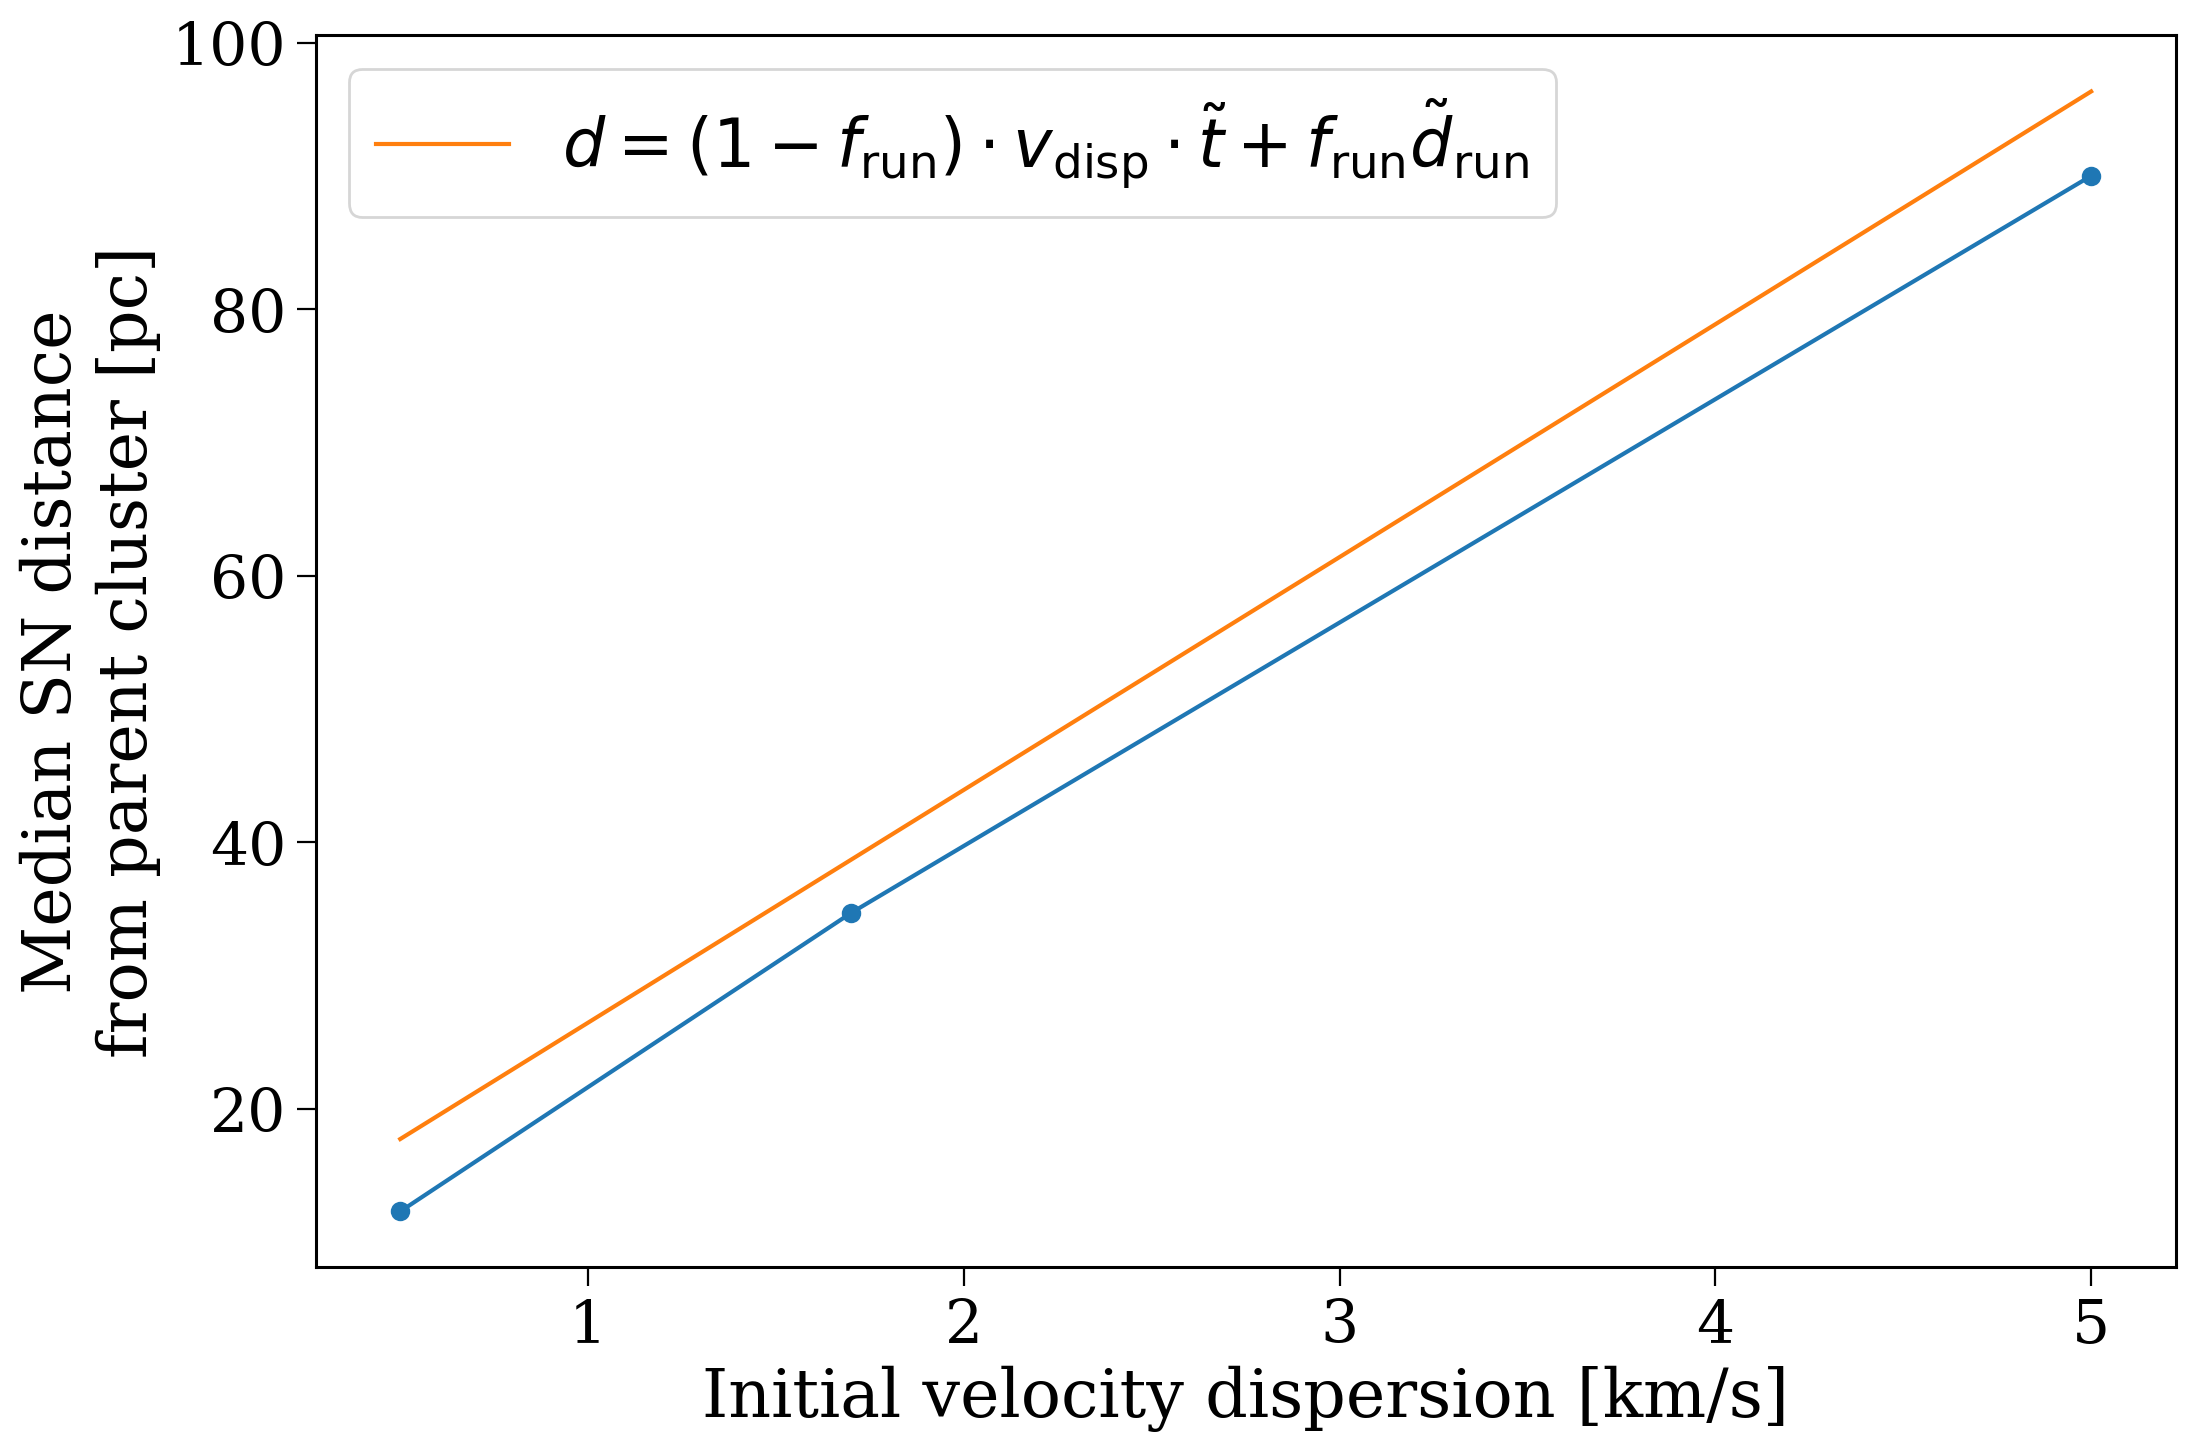

In [206]:
mean_time = 21.3
mean_run = 50
run_frac = 0.18

plt.plot([0.5, 1.7, 5], [12.3, 34.7, 90.0], marker="o")
plt.plot([0.5, 1.7, 5], np.array([0.5, 1.7, 5]) * mean_time * (1 - run_frac) + run_frac * mean_run, label=r"$d = (1 - f_{\rm run}) \cdot v_{\rm disp} \cdot \tilde{t} + f_{\rm run} \tilde{d}_{\rm run} $")

plt.xlabel("Initial velocity dispersion [km/s]")
plt.ylabel("Median SN distance\nfrom parent cluster [pc]")
plt.legend()

plt.show()

In [442]:
(thing.iloc[1, 1:] / thing.iloc[0, 1:]).astype(float).round(2)

time_50        1.36
distance_50    1.26
n_per_100      1.18
dtype: float64

# Variation plots

In [59]:
plot_settings = {
    "bin": {
        "files": ["fiducial", "ce-0.1", "ce-10.0", "qcritB-0.0", "qcritB-1000.0", "beta-0.0", "beta-0.5", "beta-1.0",
                  "ccsn-20", "ecsn-265", "no-fallback"],
        "group_start_inds": [1, 5, 8],
        "group_labels": ["Fiducial", "Common-Envelope", "Mass Transfer", "Supernova kicks"],
        "fiducial_settings": [r"$\alpha_{\rm CE} = 1.0$", r"$\beta \propto 10 \tau_{\rm th, acc}$",
                              r"$\sigma_{\rm low} = 20 \, {\rm km/s}$", r"$\sigma_{\rm CC} = 265 \, {\rm km/s}$"]
    },
    "ini": {
        "files": ["fiducial", "imf-1.9", "imf-2.7", "porb-0", "porb-minus1", "porb-max-3", "q-plus1", "q-minus1"],
        "group_start_inds": [1, 3, 6],
        "group_labels": ["Fiducial", "Initial mass function", "Initial orbital period", "Initial mass ratio"],
        "fiducial_settings": [r"$\alpha_{IMF} = -2.3$", r"$\pi=-0.55$", r"$\kappa=0$"],
        "an_fs_mod": 1.2,
        "rotate_labels": 20,
    },
    "z": {
        "files": ["fiducial", "Z-0.5", "Z-0.2", "Z-0.1", "Z-0.05"],
        "group_start_inds": [1, 10],
        "group_labels": ["Fiducial", "Metallicity"],
        "fiducial_settings": [r"$\bar{Z} = \bar{Z}_{\rm m11h}$"],
        "an_fs_mod": 1.5,
        "rotate_labels": 0,
    },
    "gal": {
        "files": ["fiducial", "v-disp-0.5", "v-disp-5", "r442-Zx2"],
        "group_start_inds": [1, 3],
        "group_labels": ["Fiducial", "Initial velocity dispersion", "Hydrodynamical\nSimulation"],
        "fiducial_settings": [r"$v_{\rm disp} = 1.7 \, {\rm km/s}$", "FIRE m11h"],
        "an_fs_mod": 1.5,
        "rotate_labels": 0,
    },
}

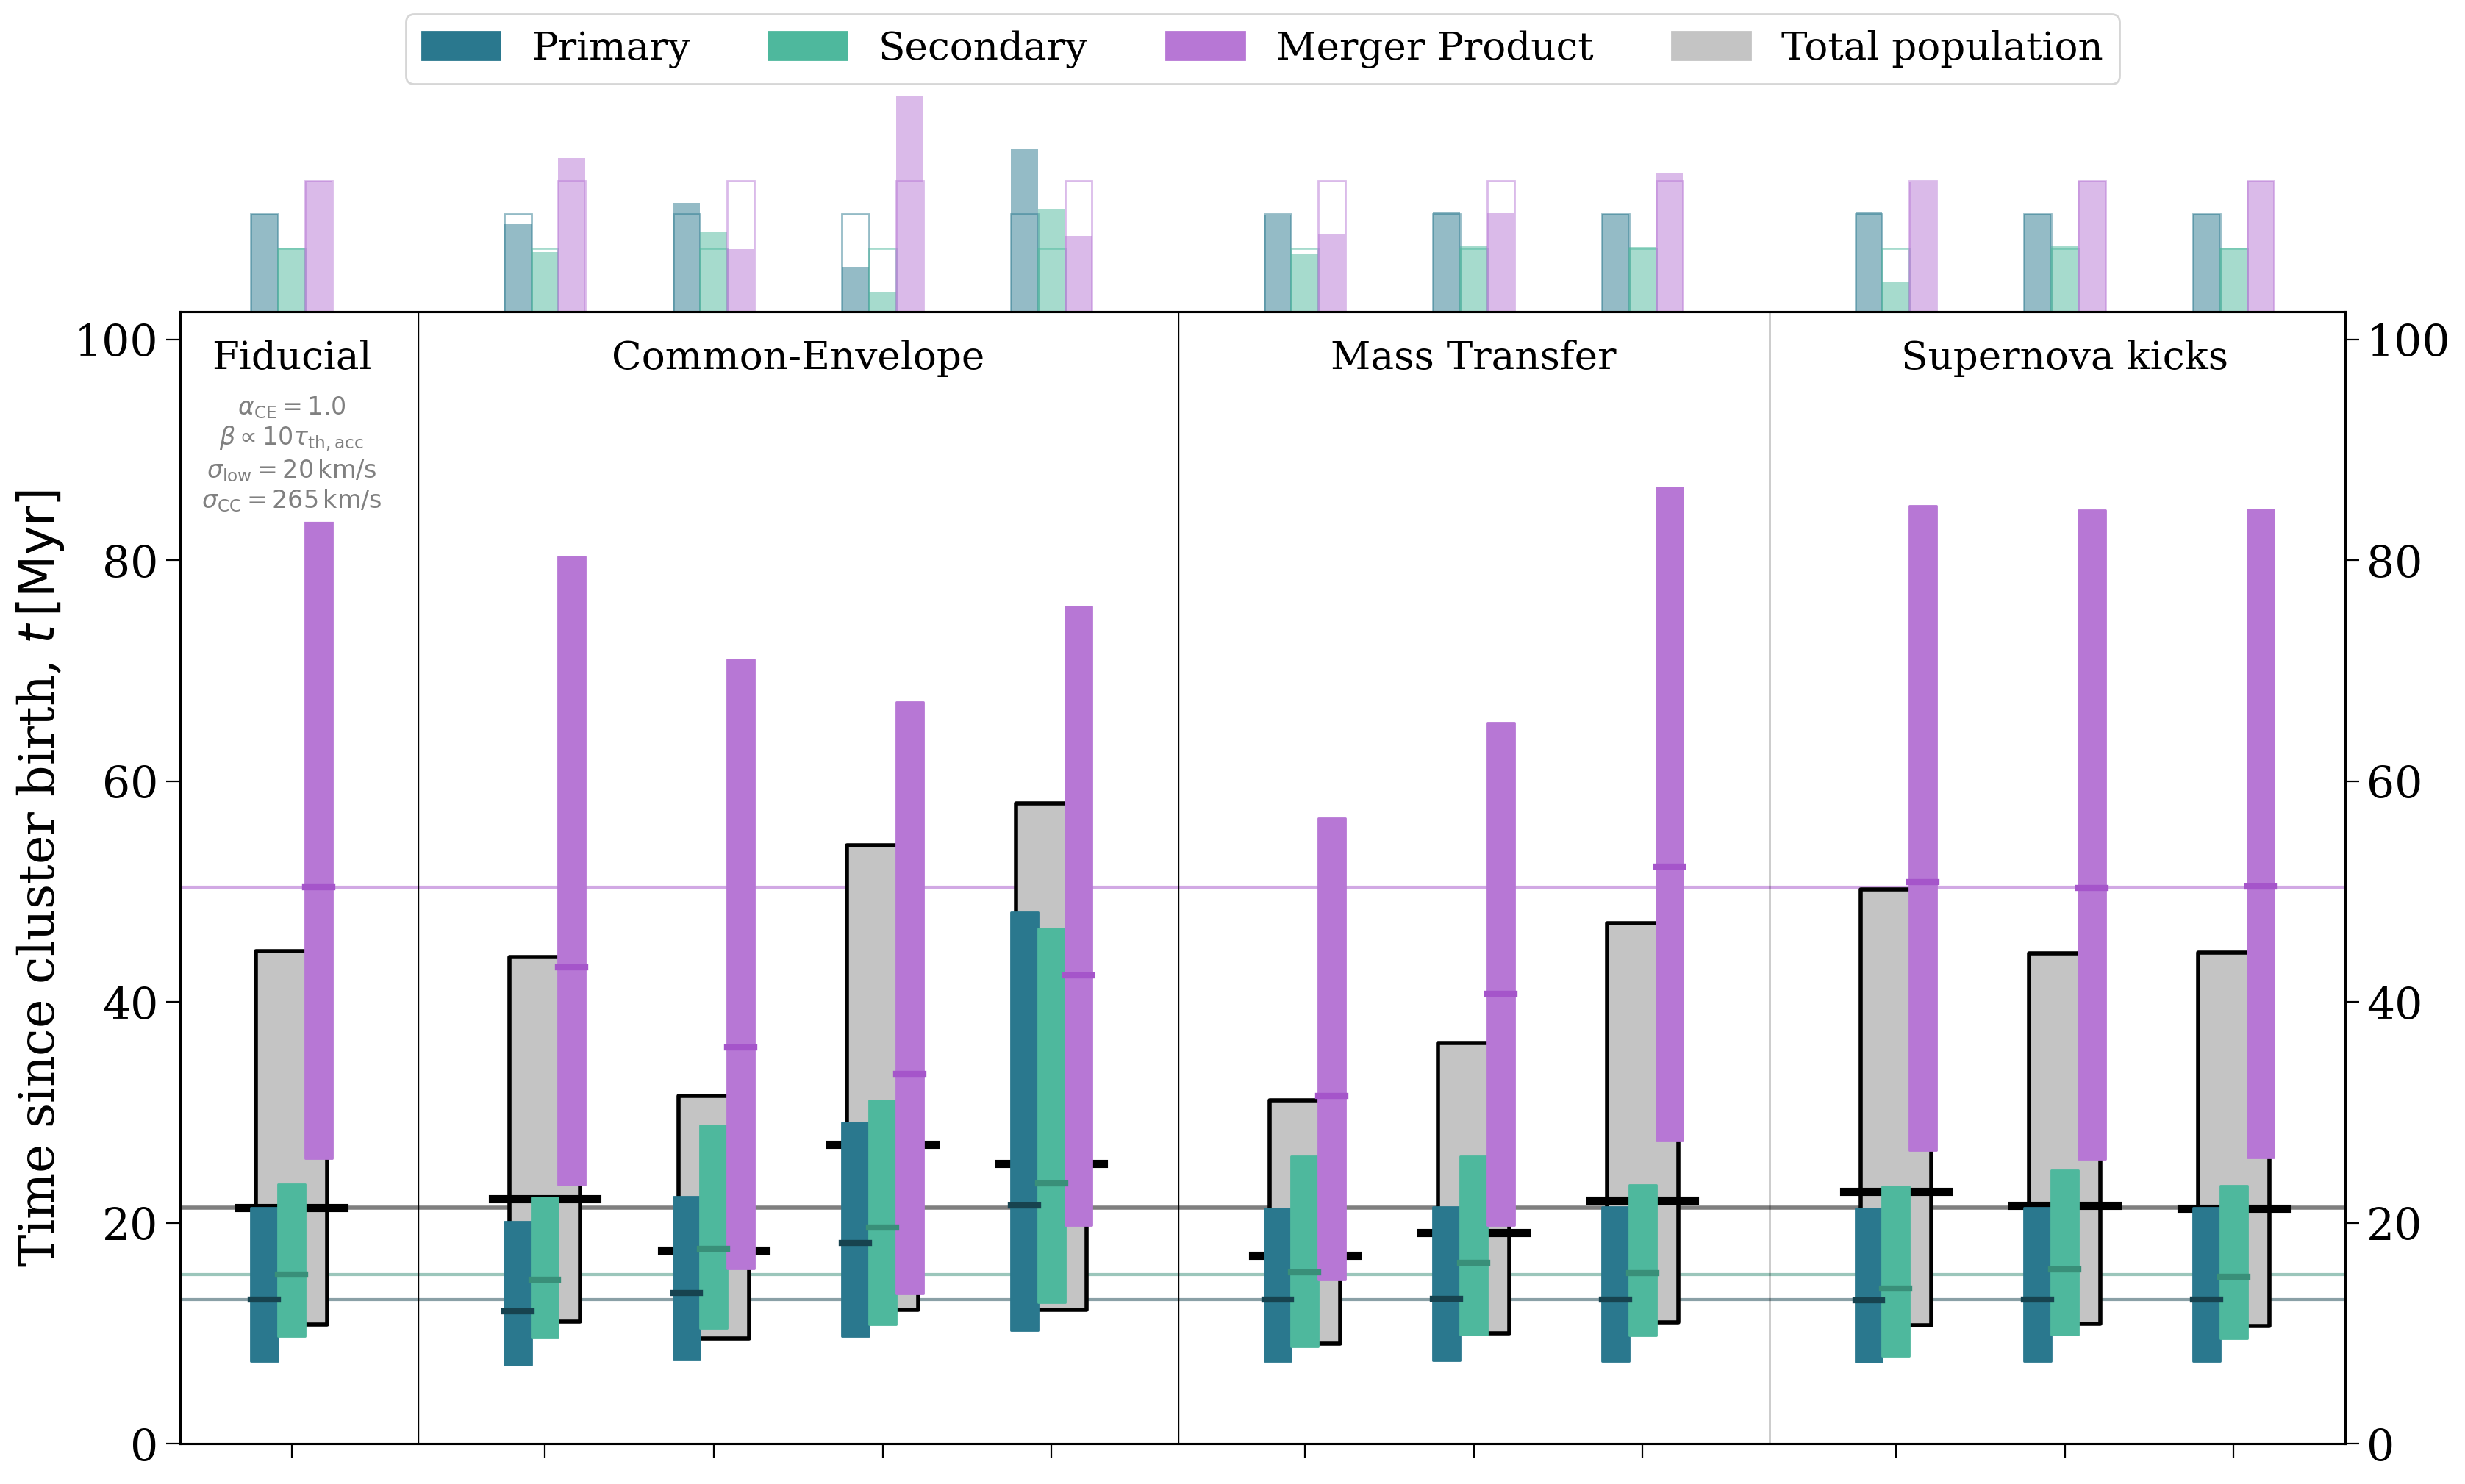

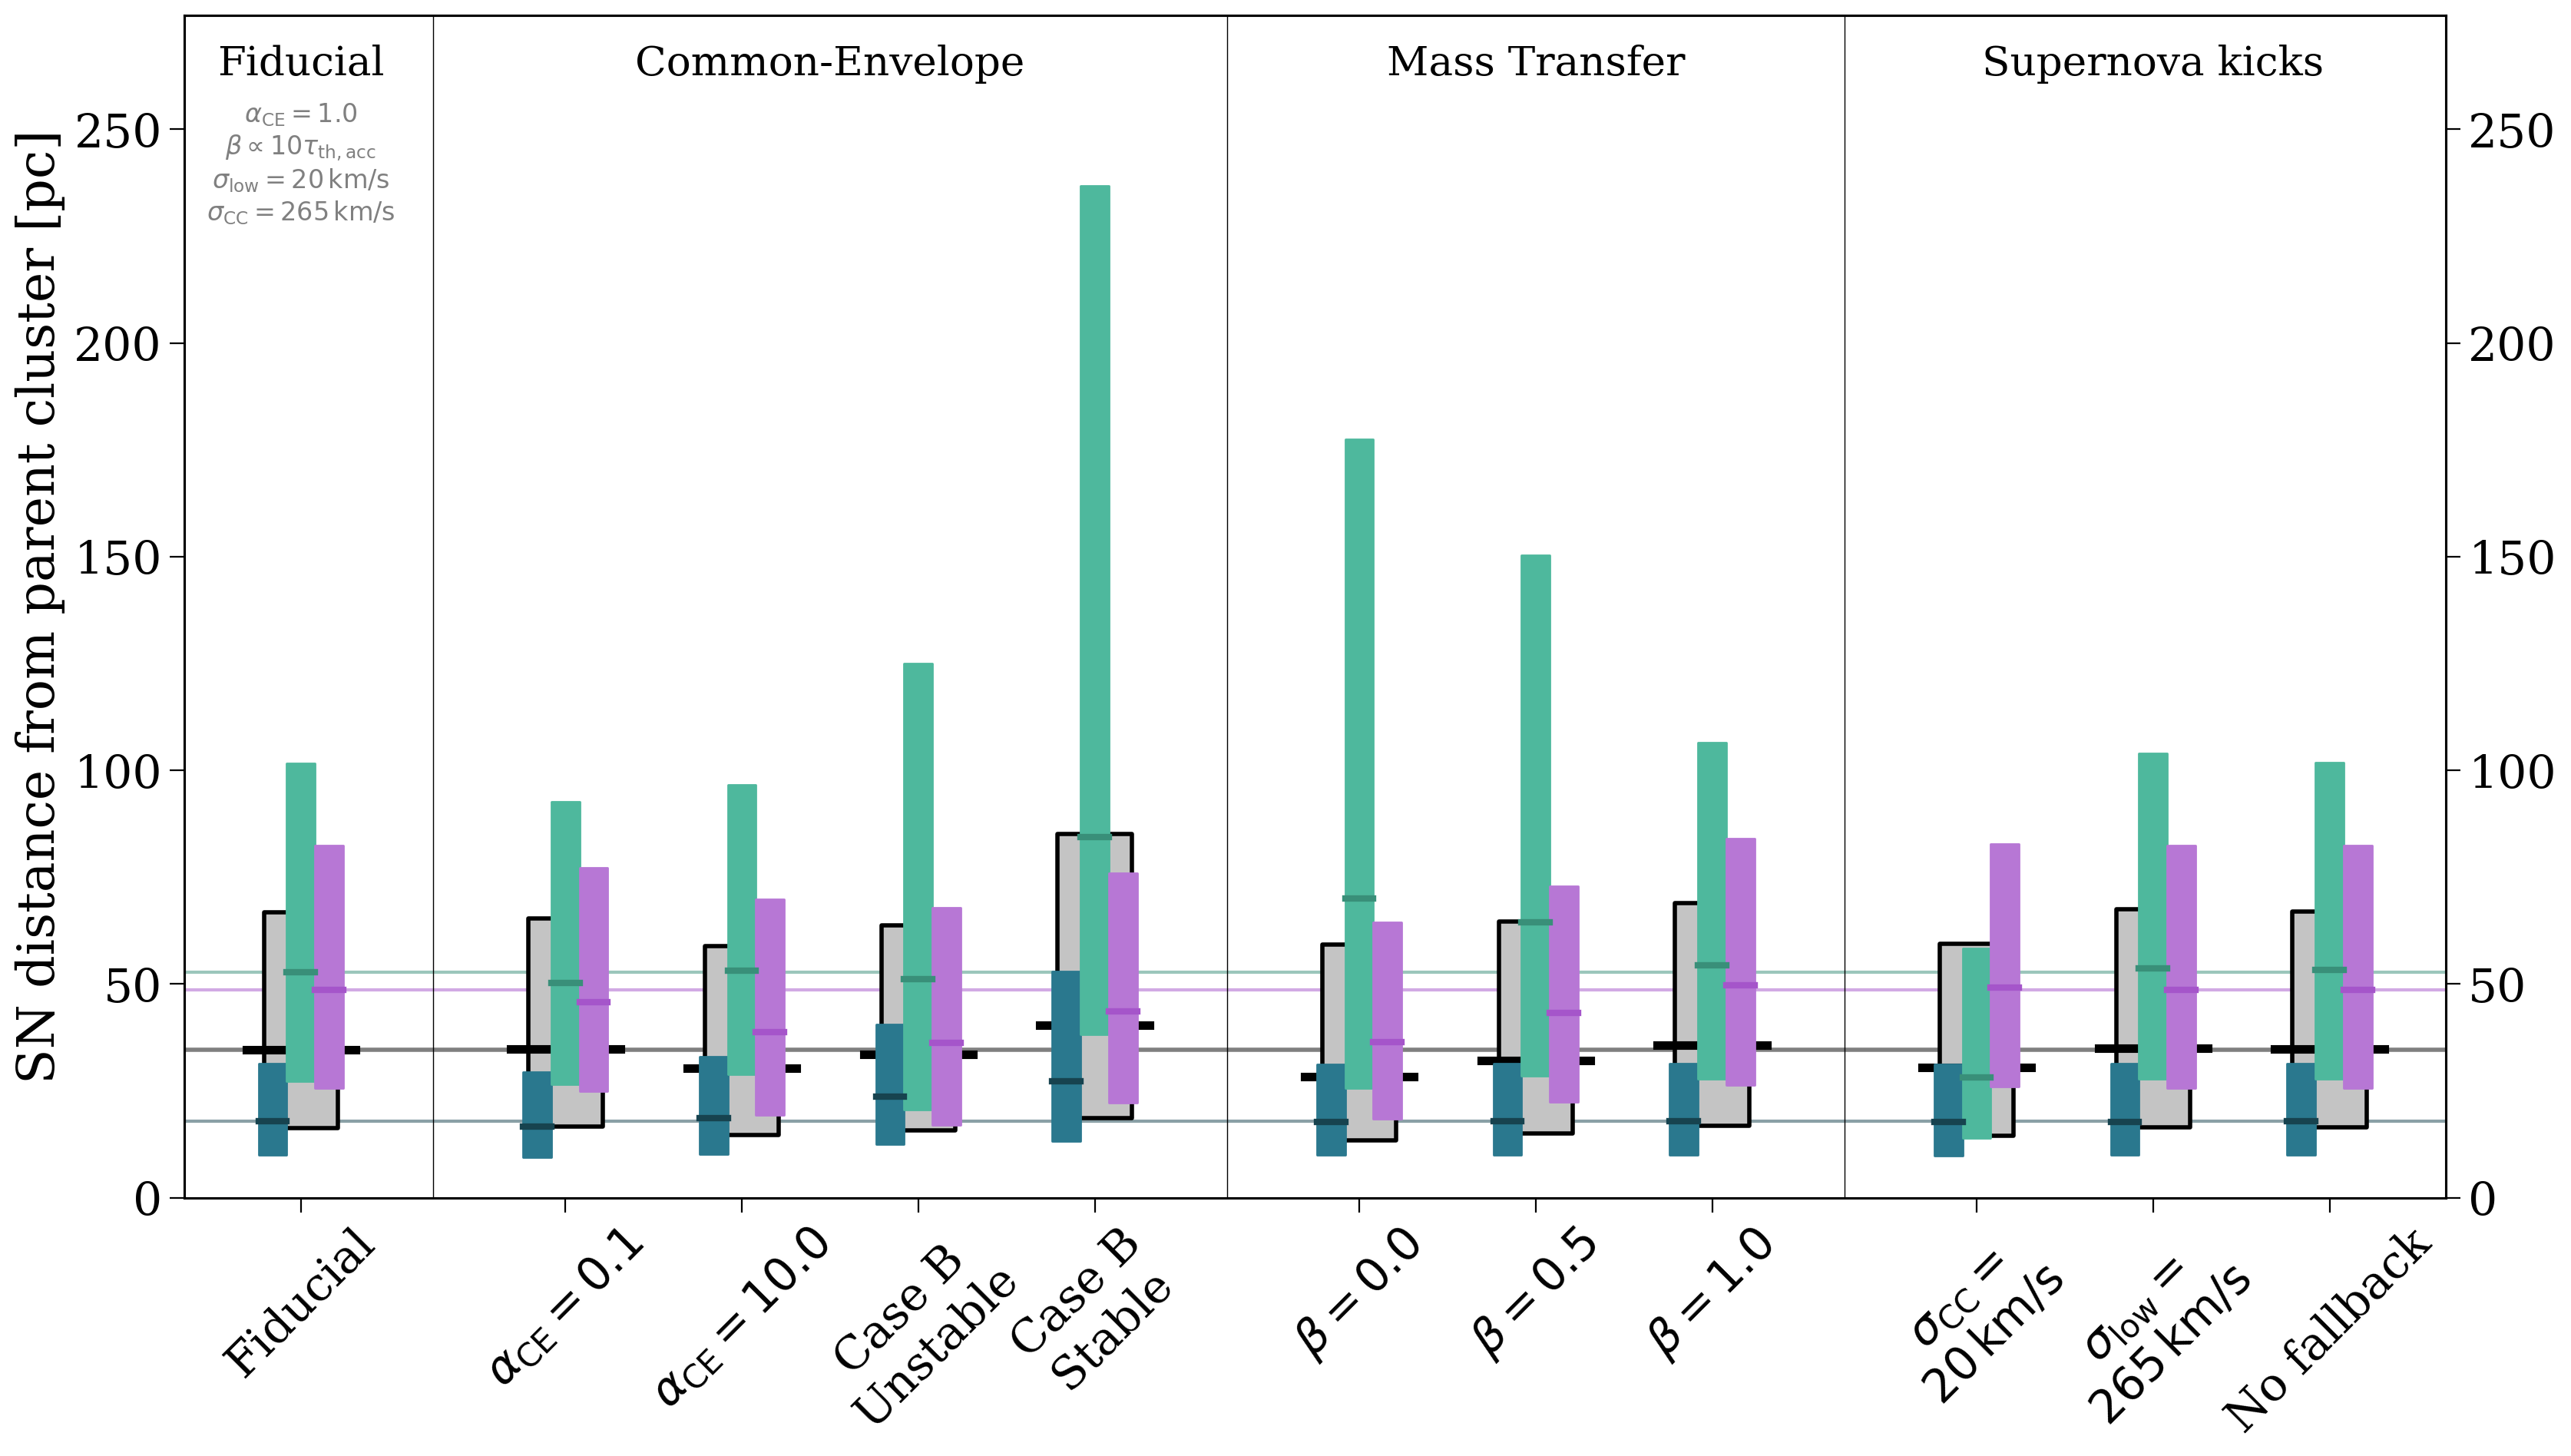

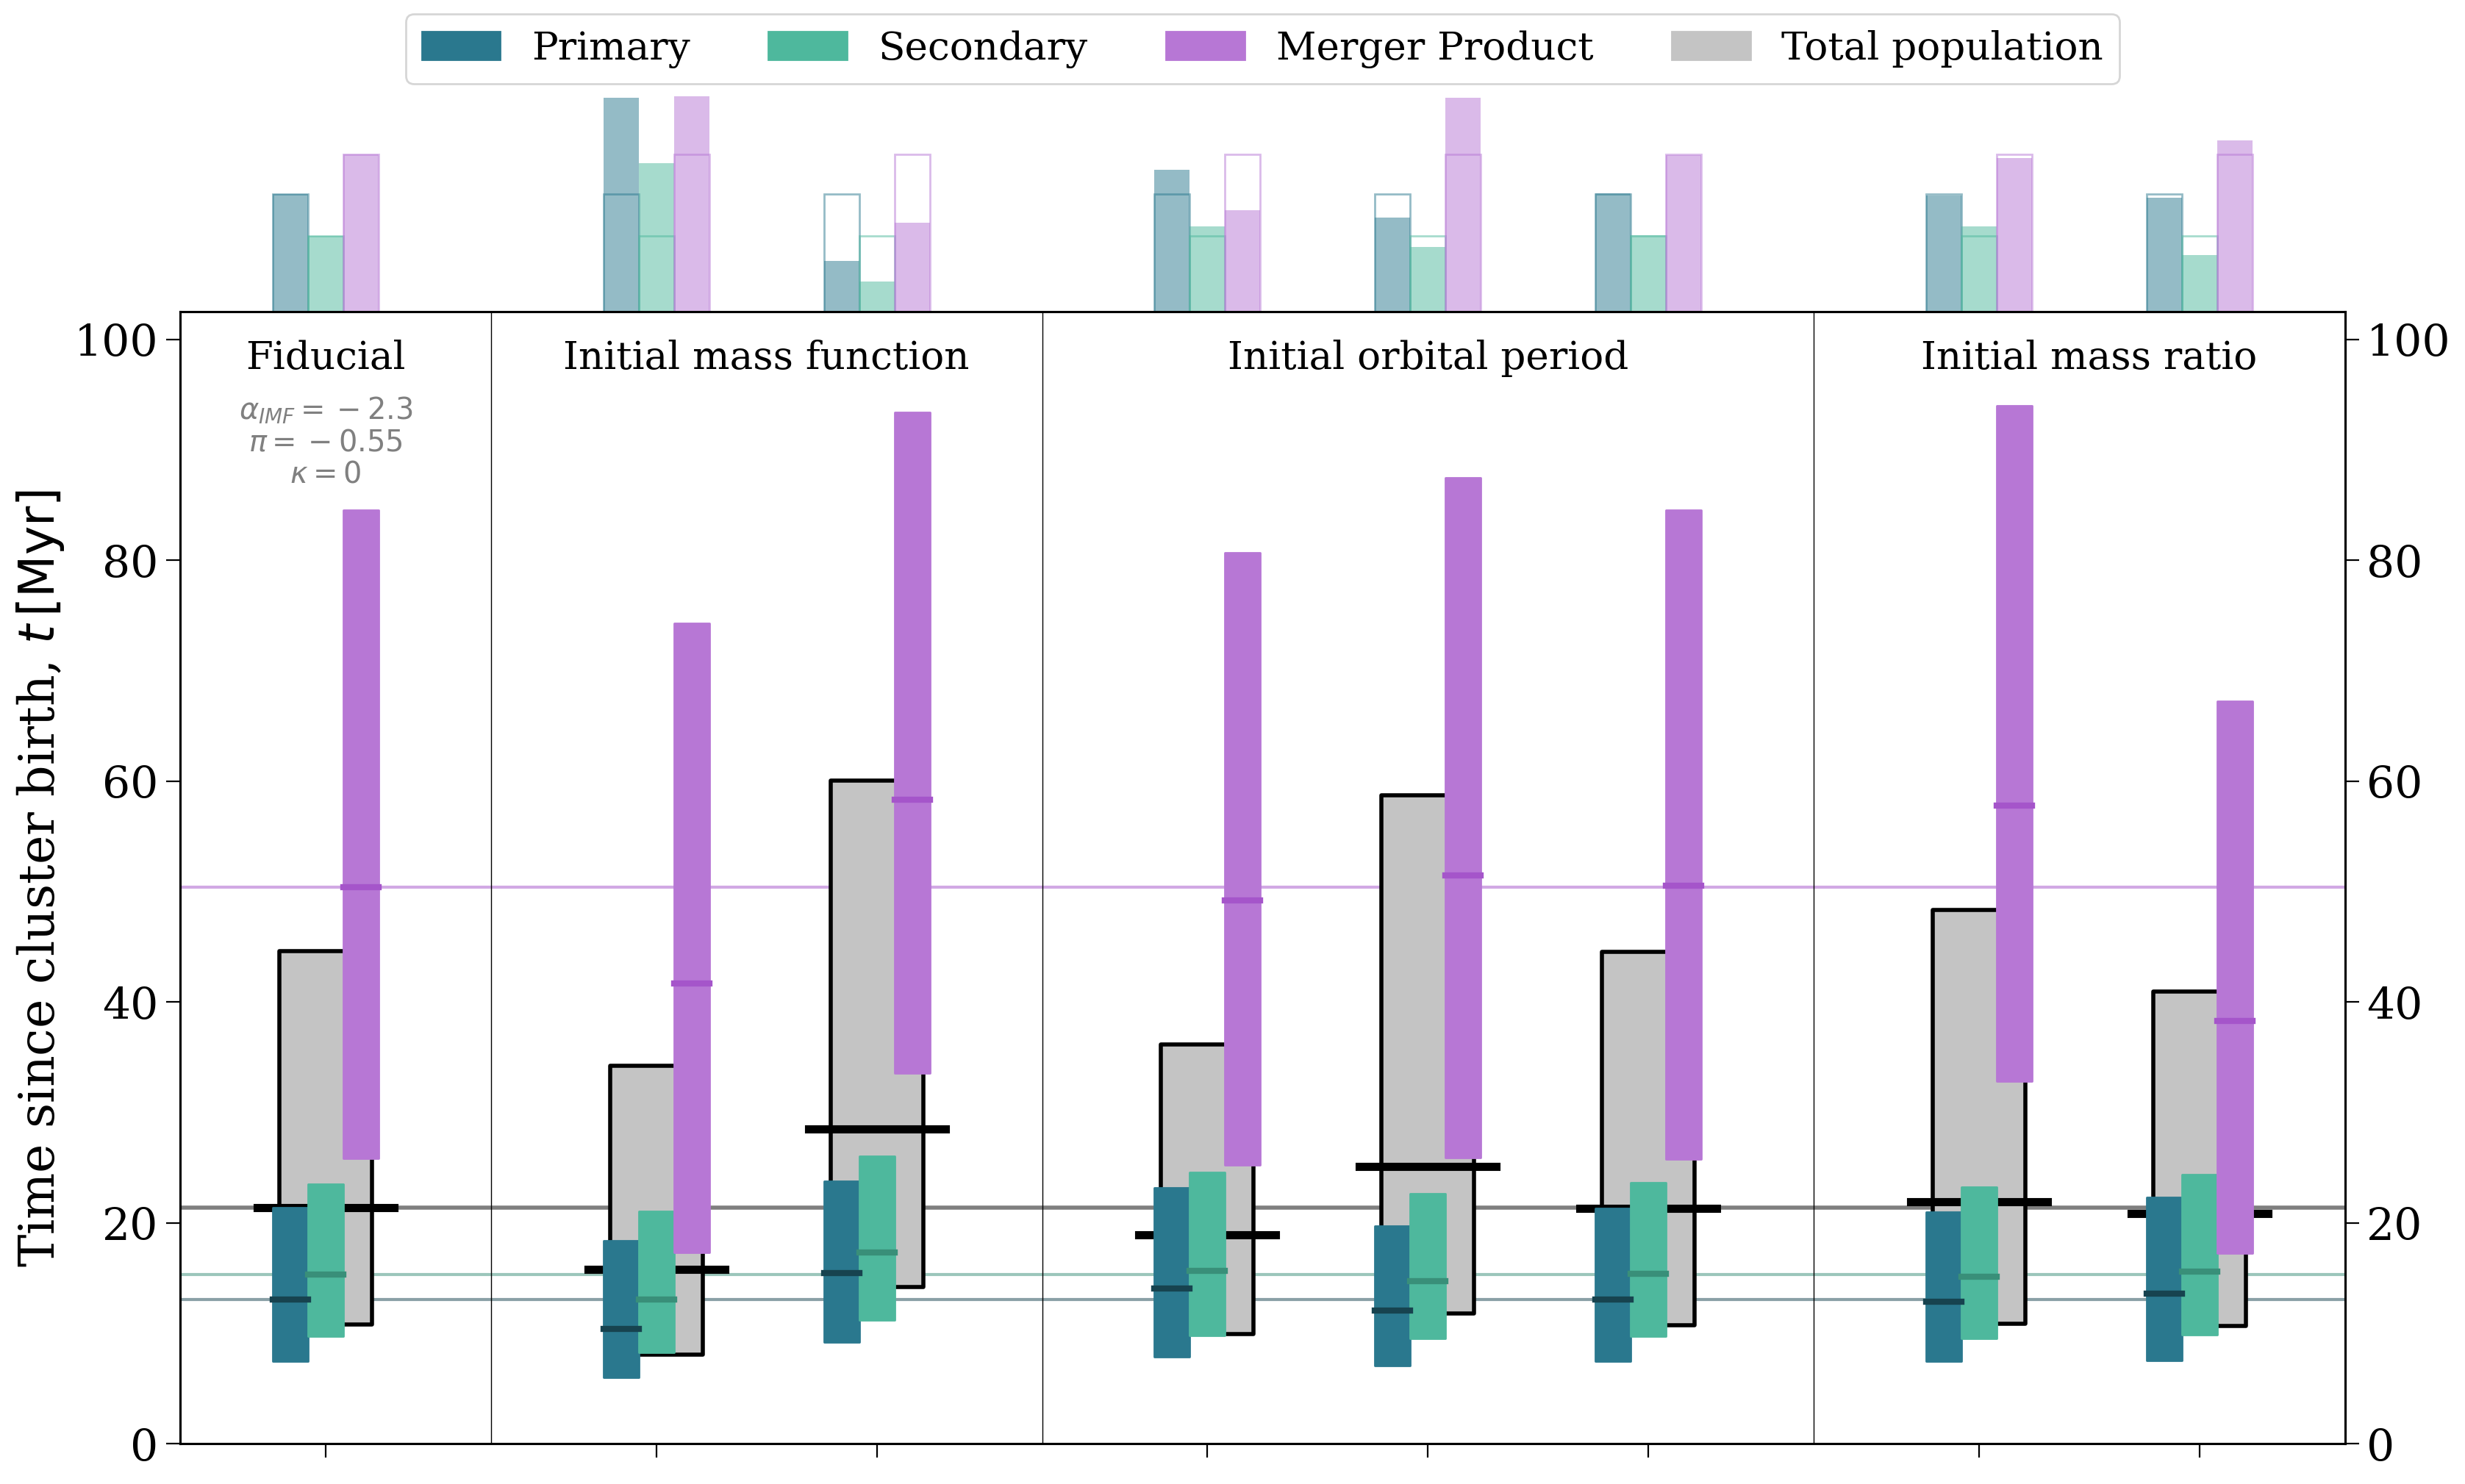

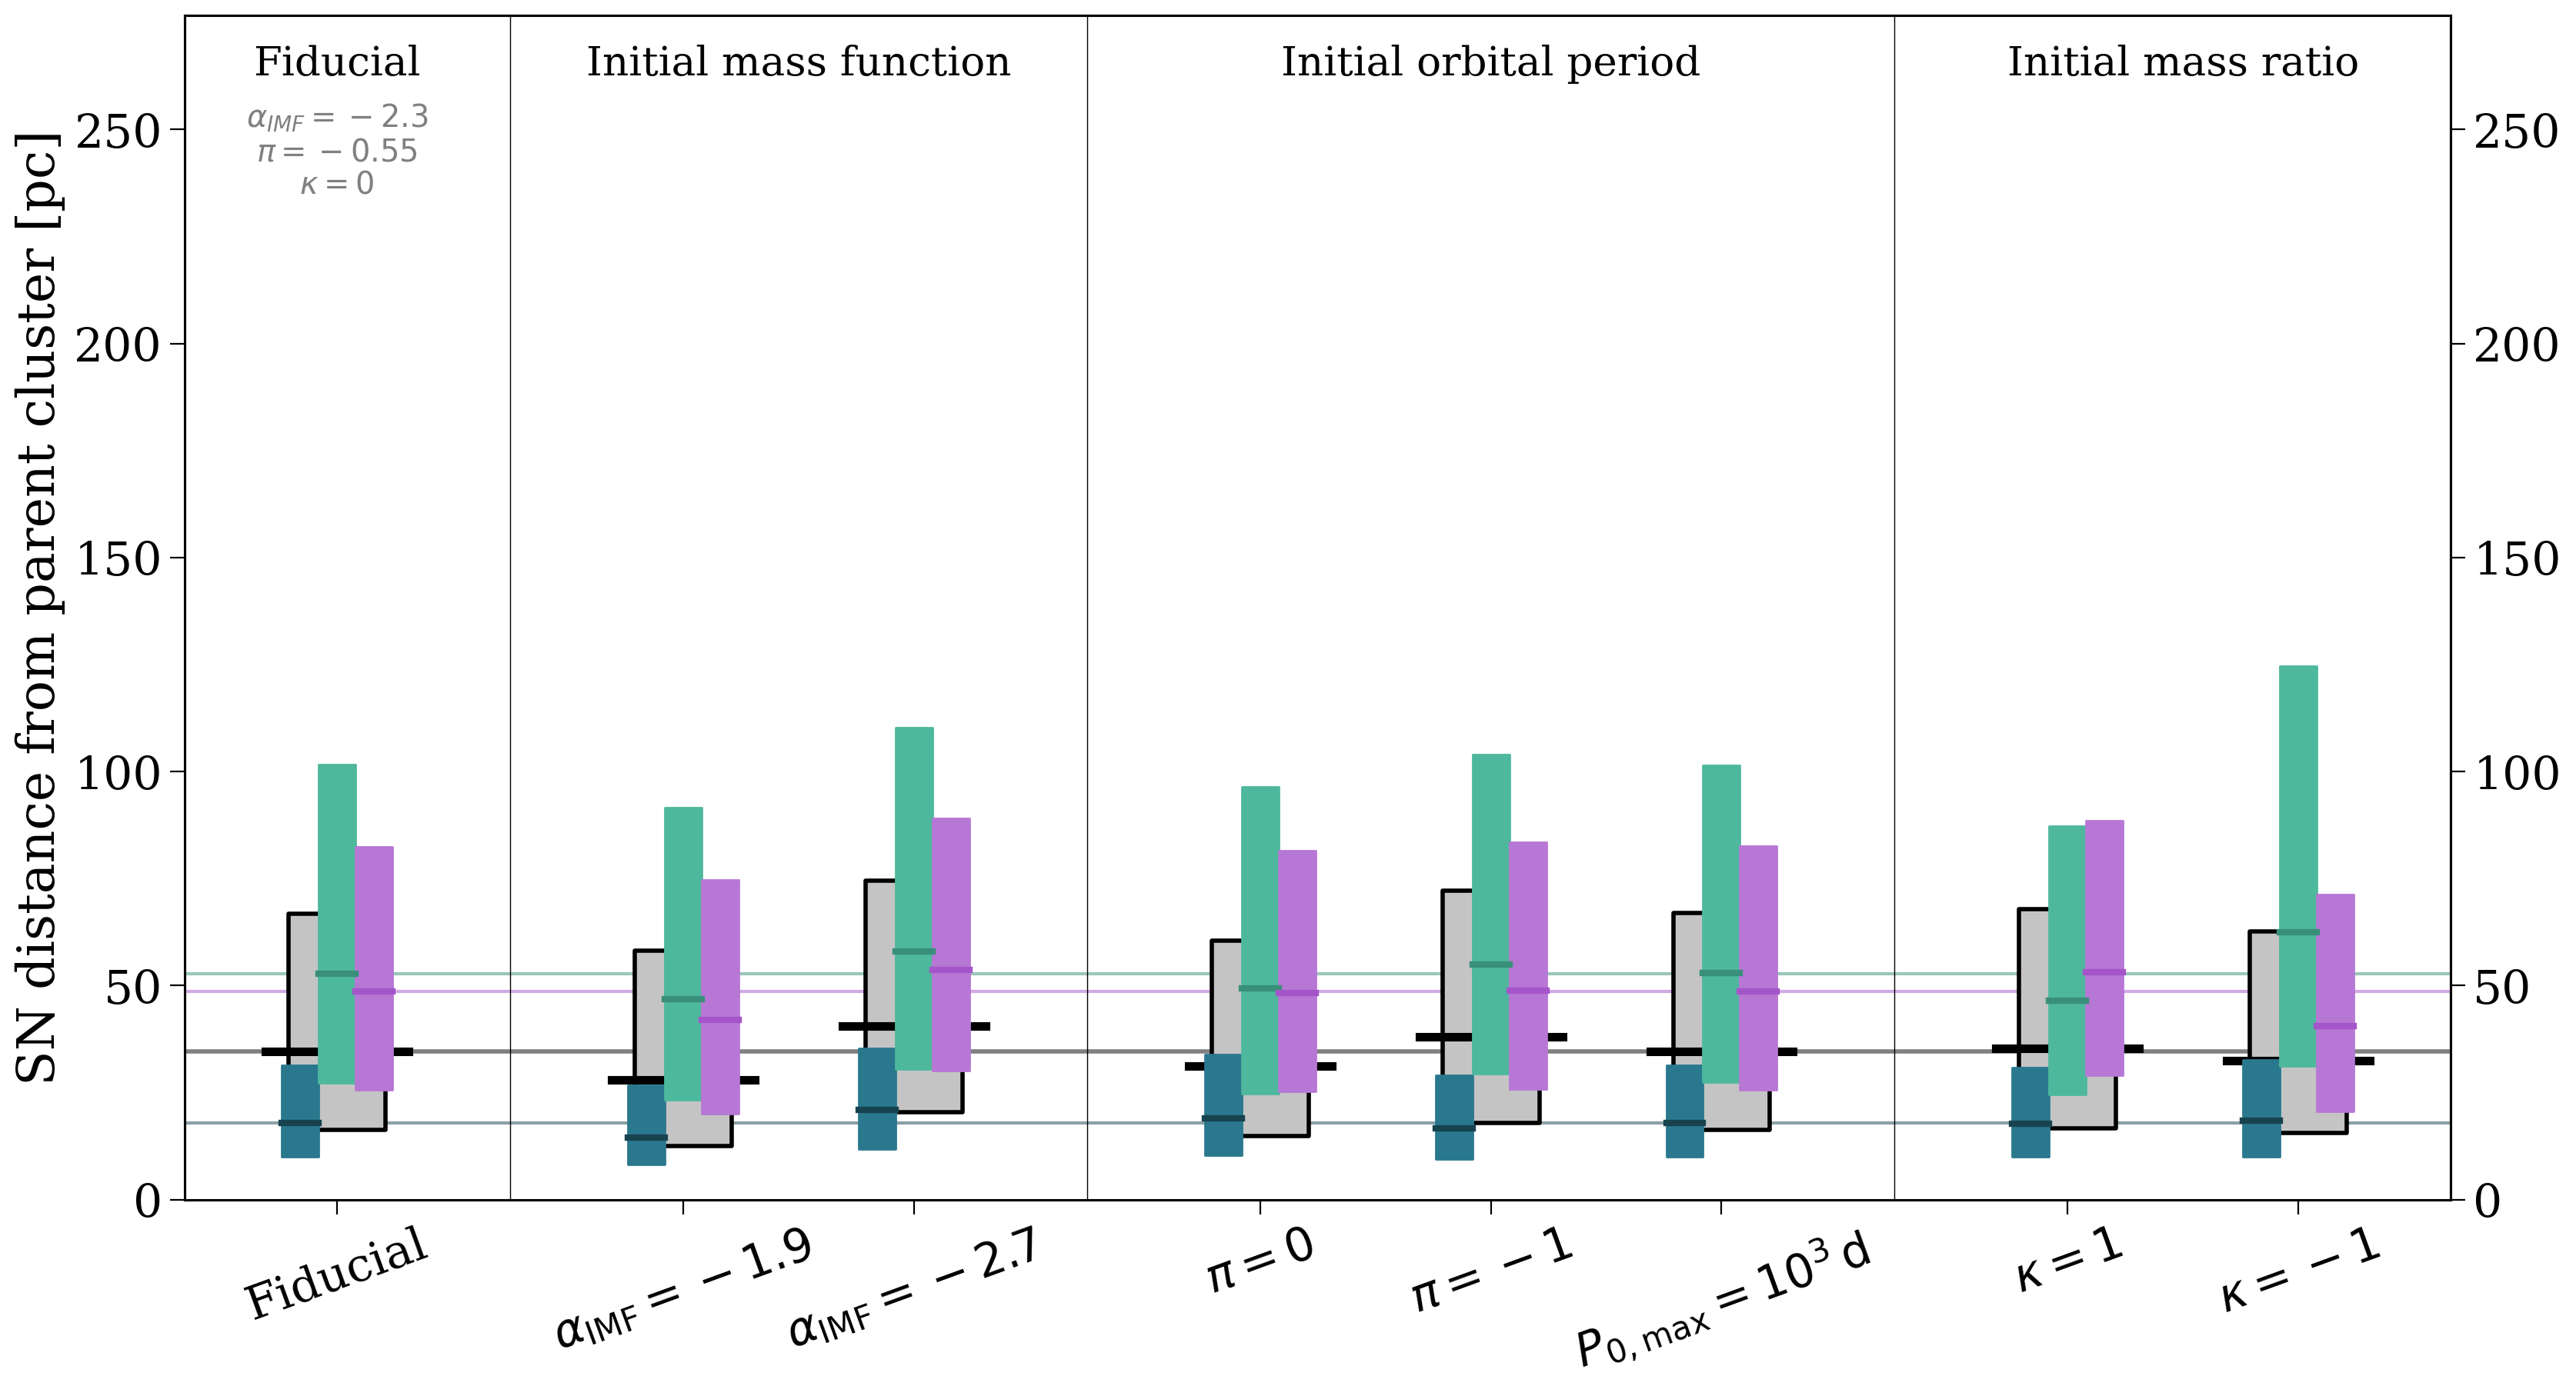

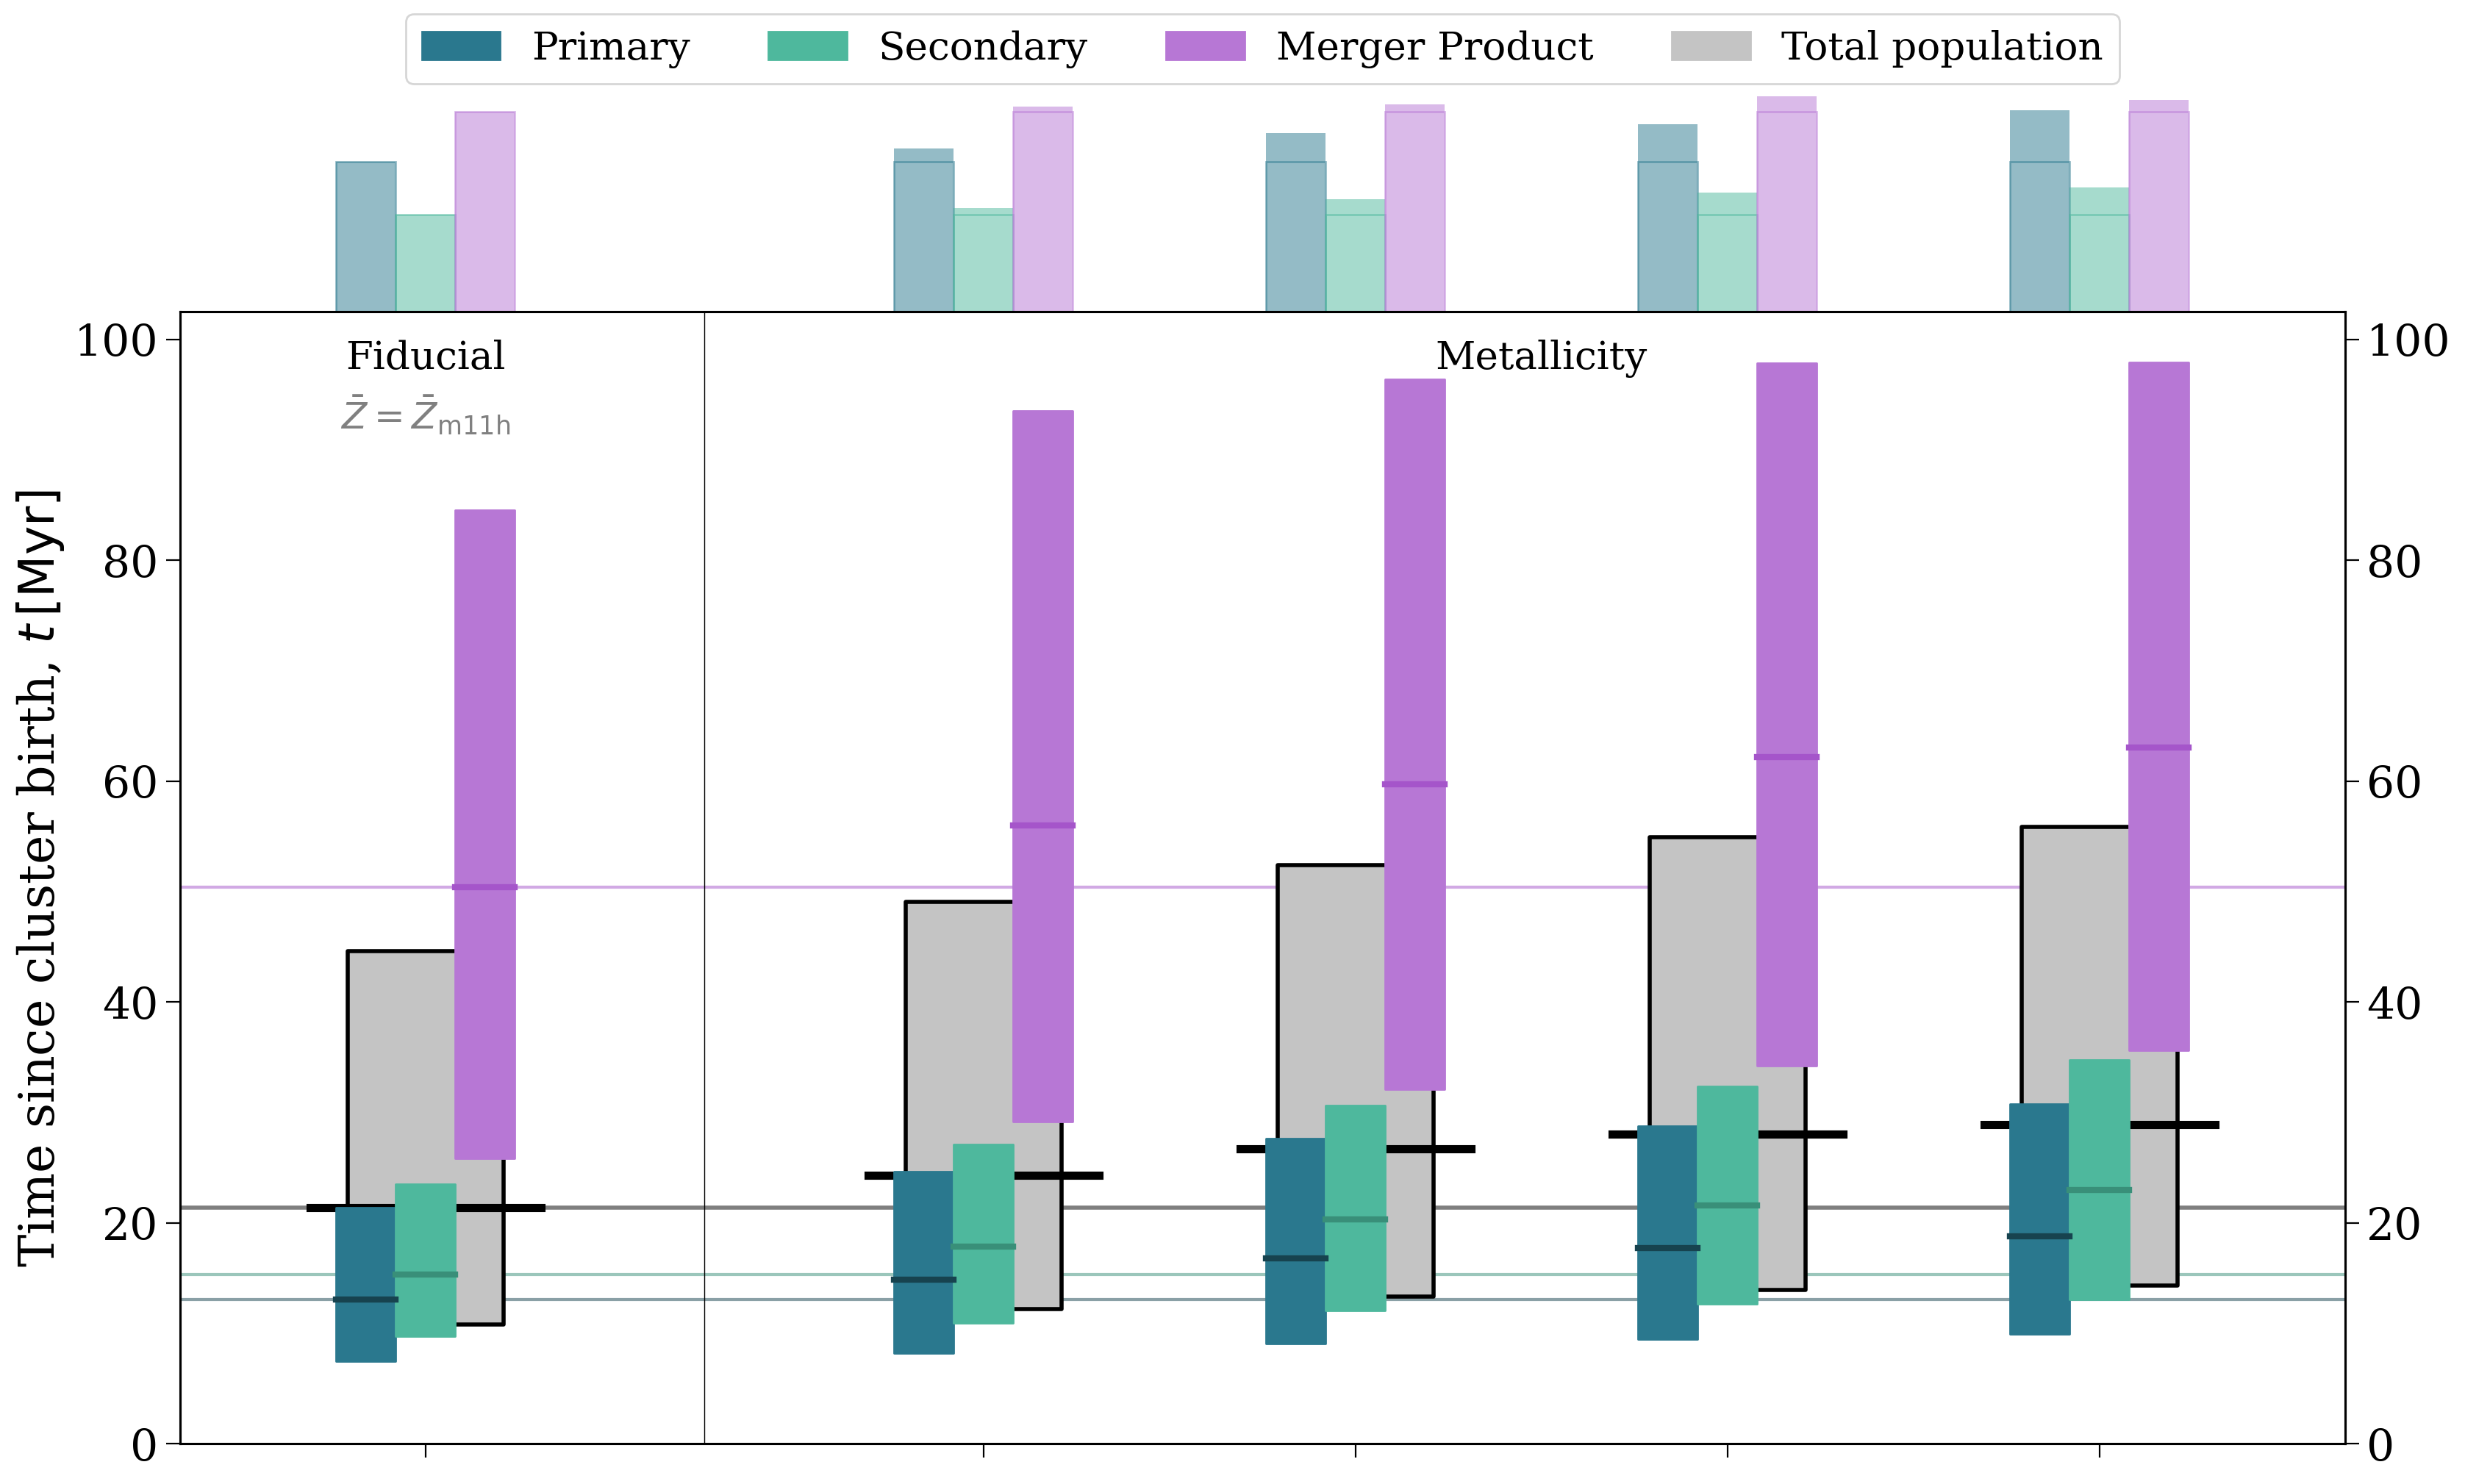

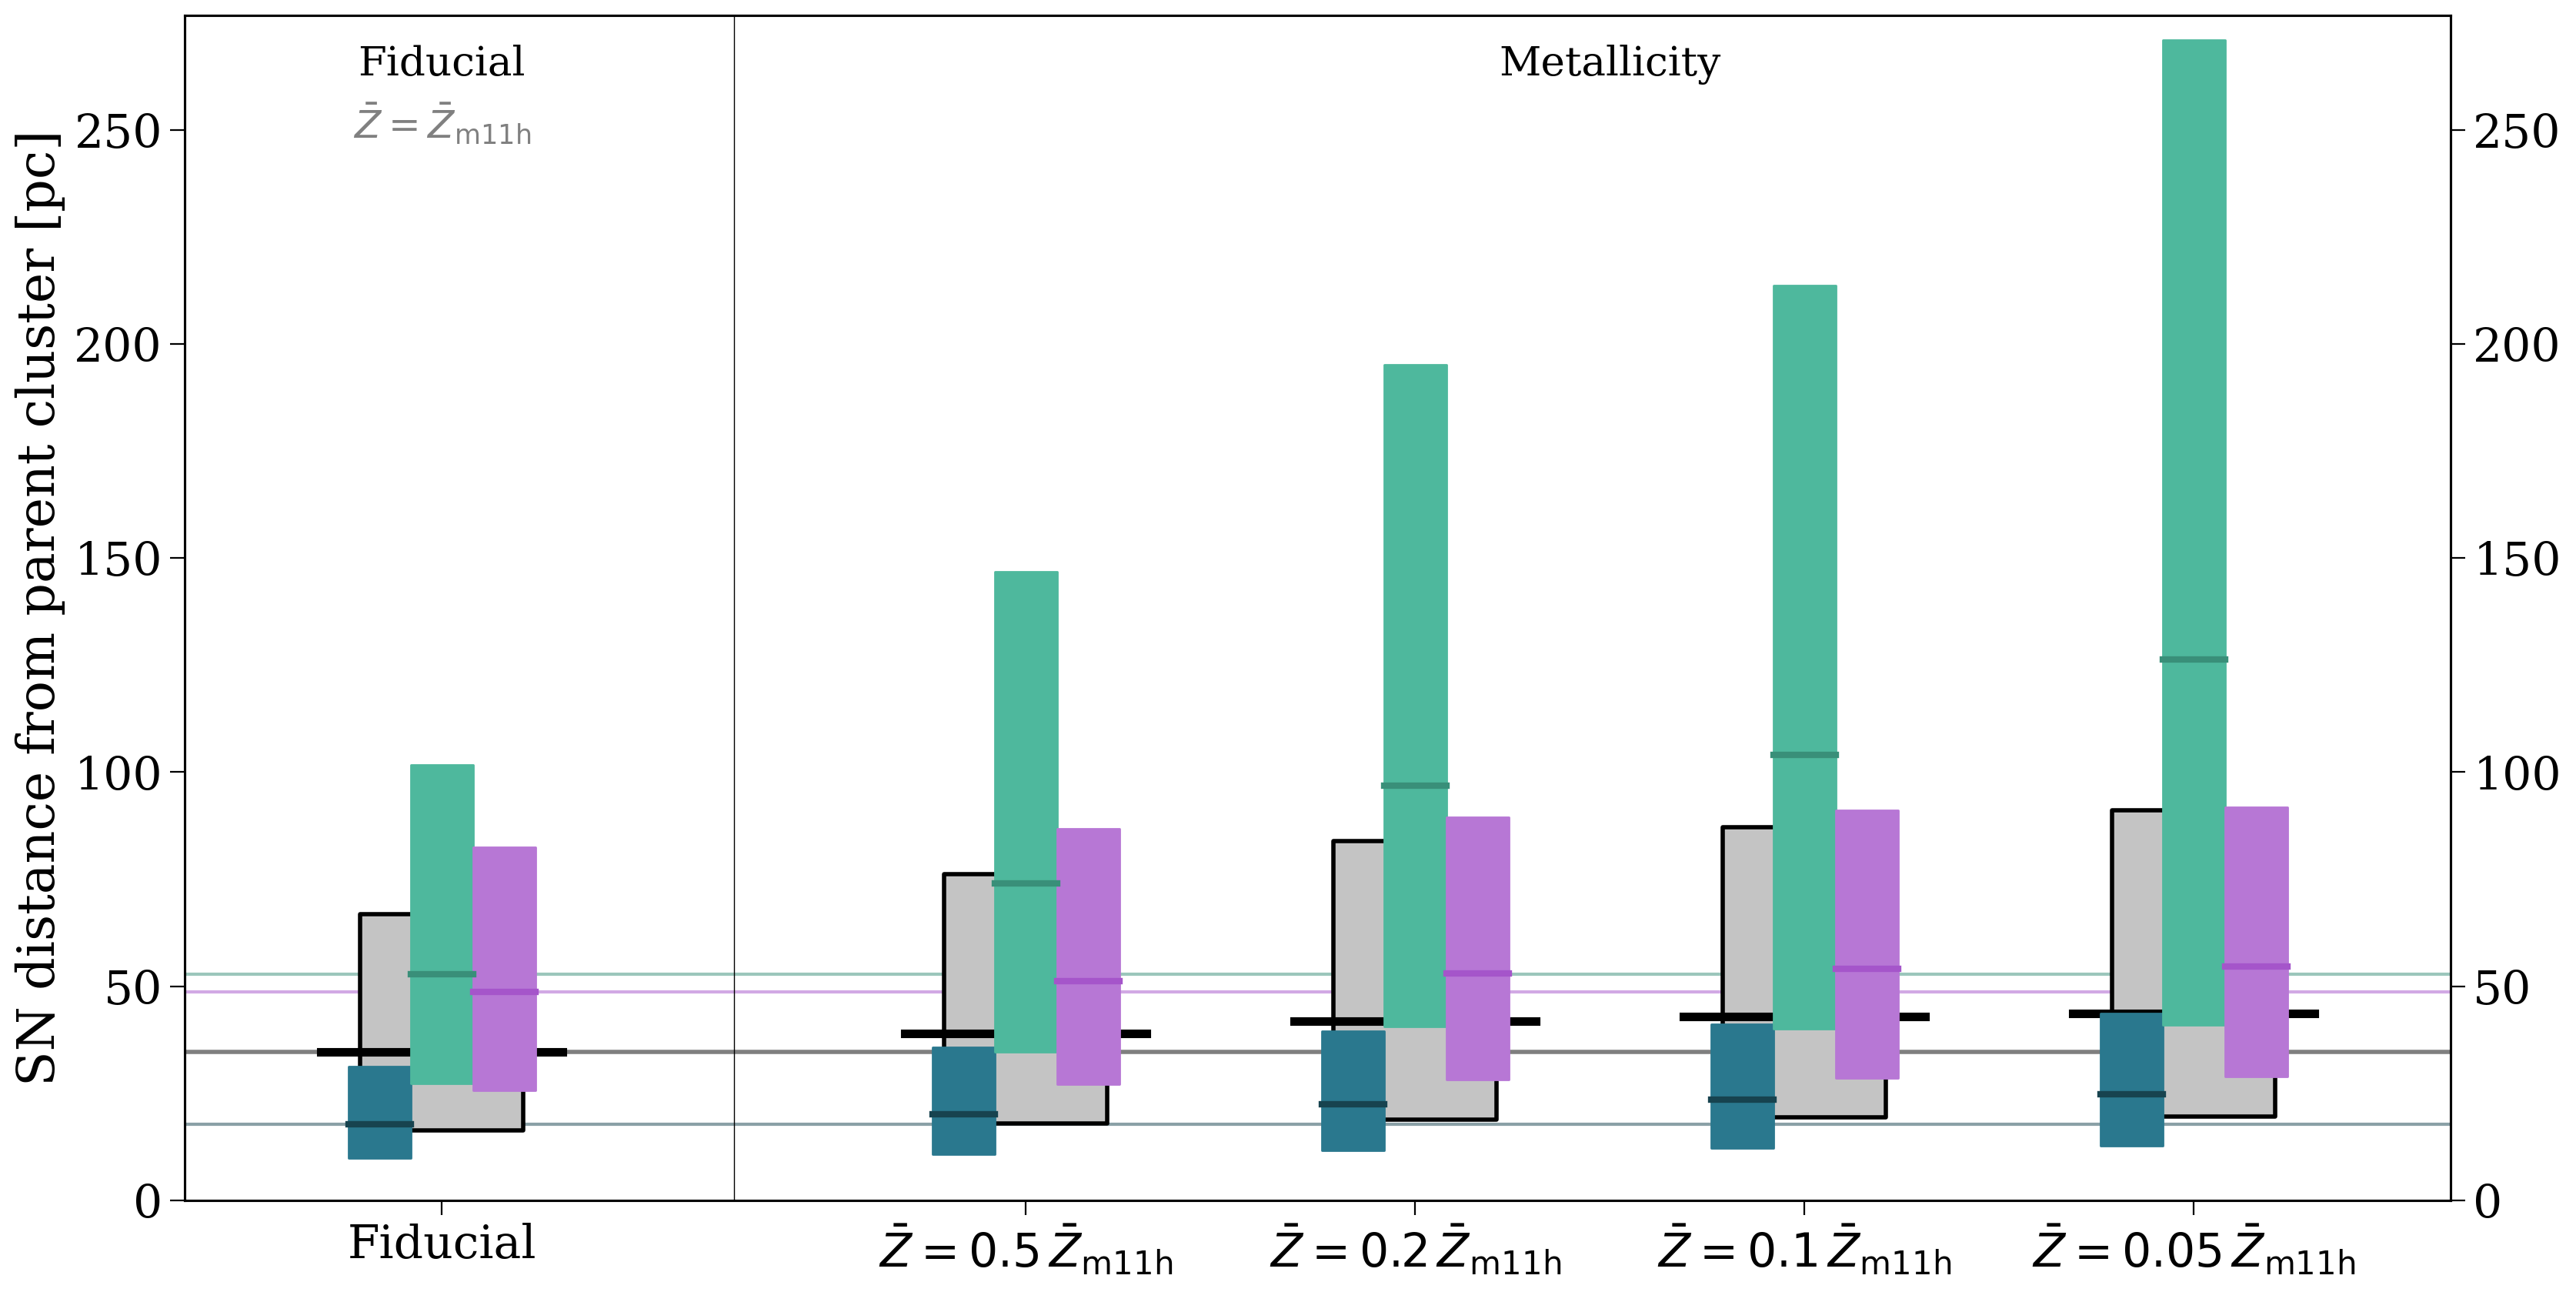

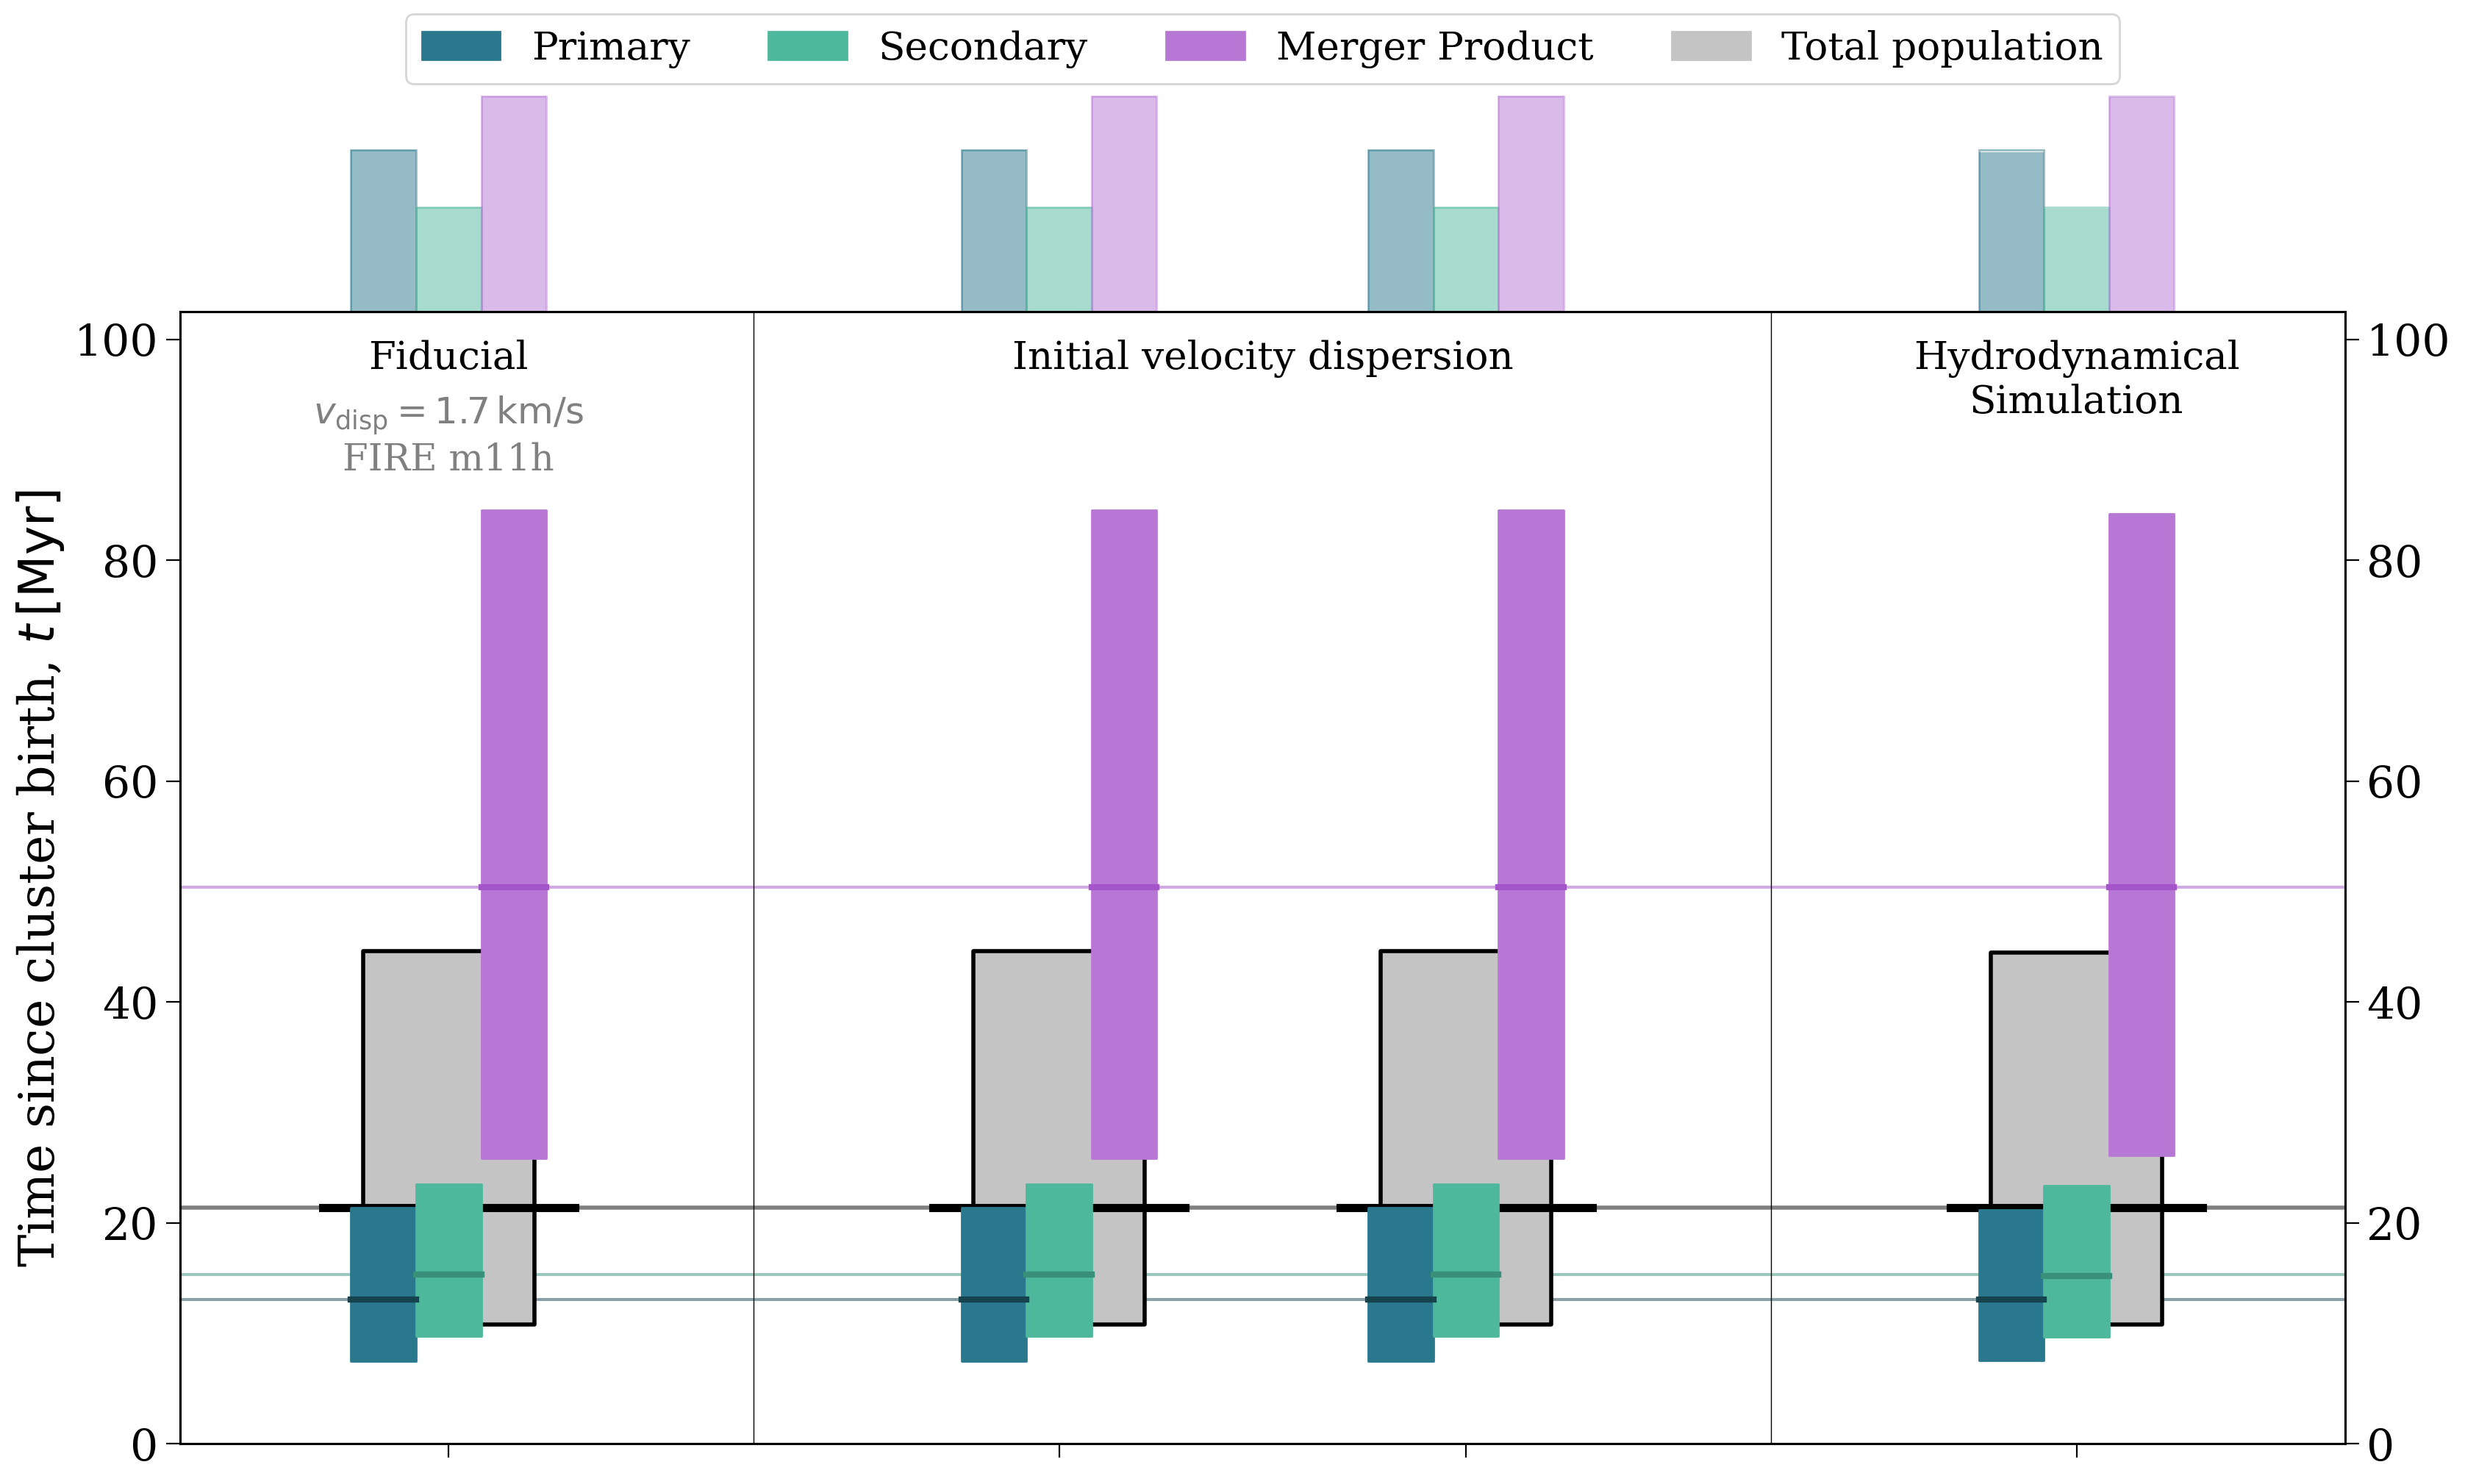

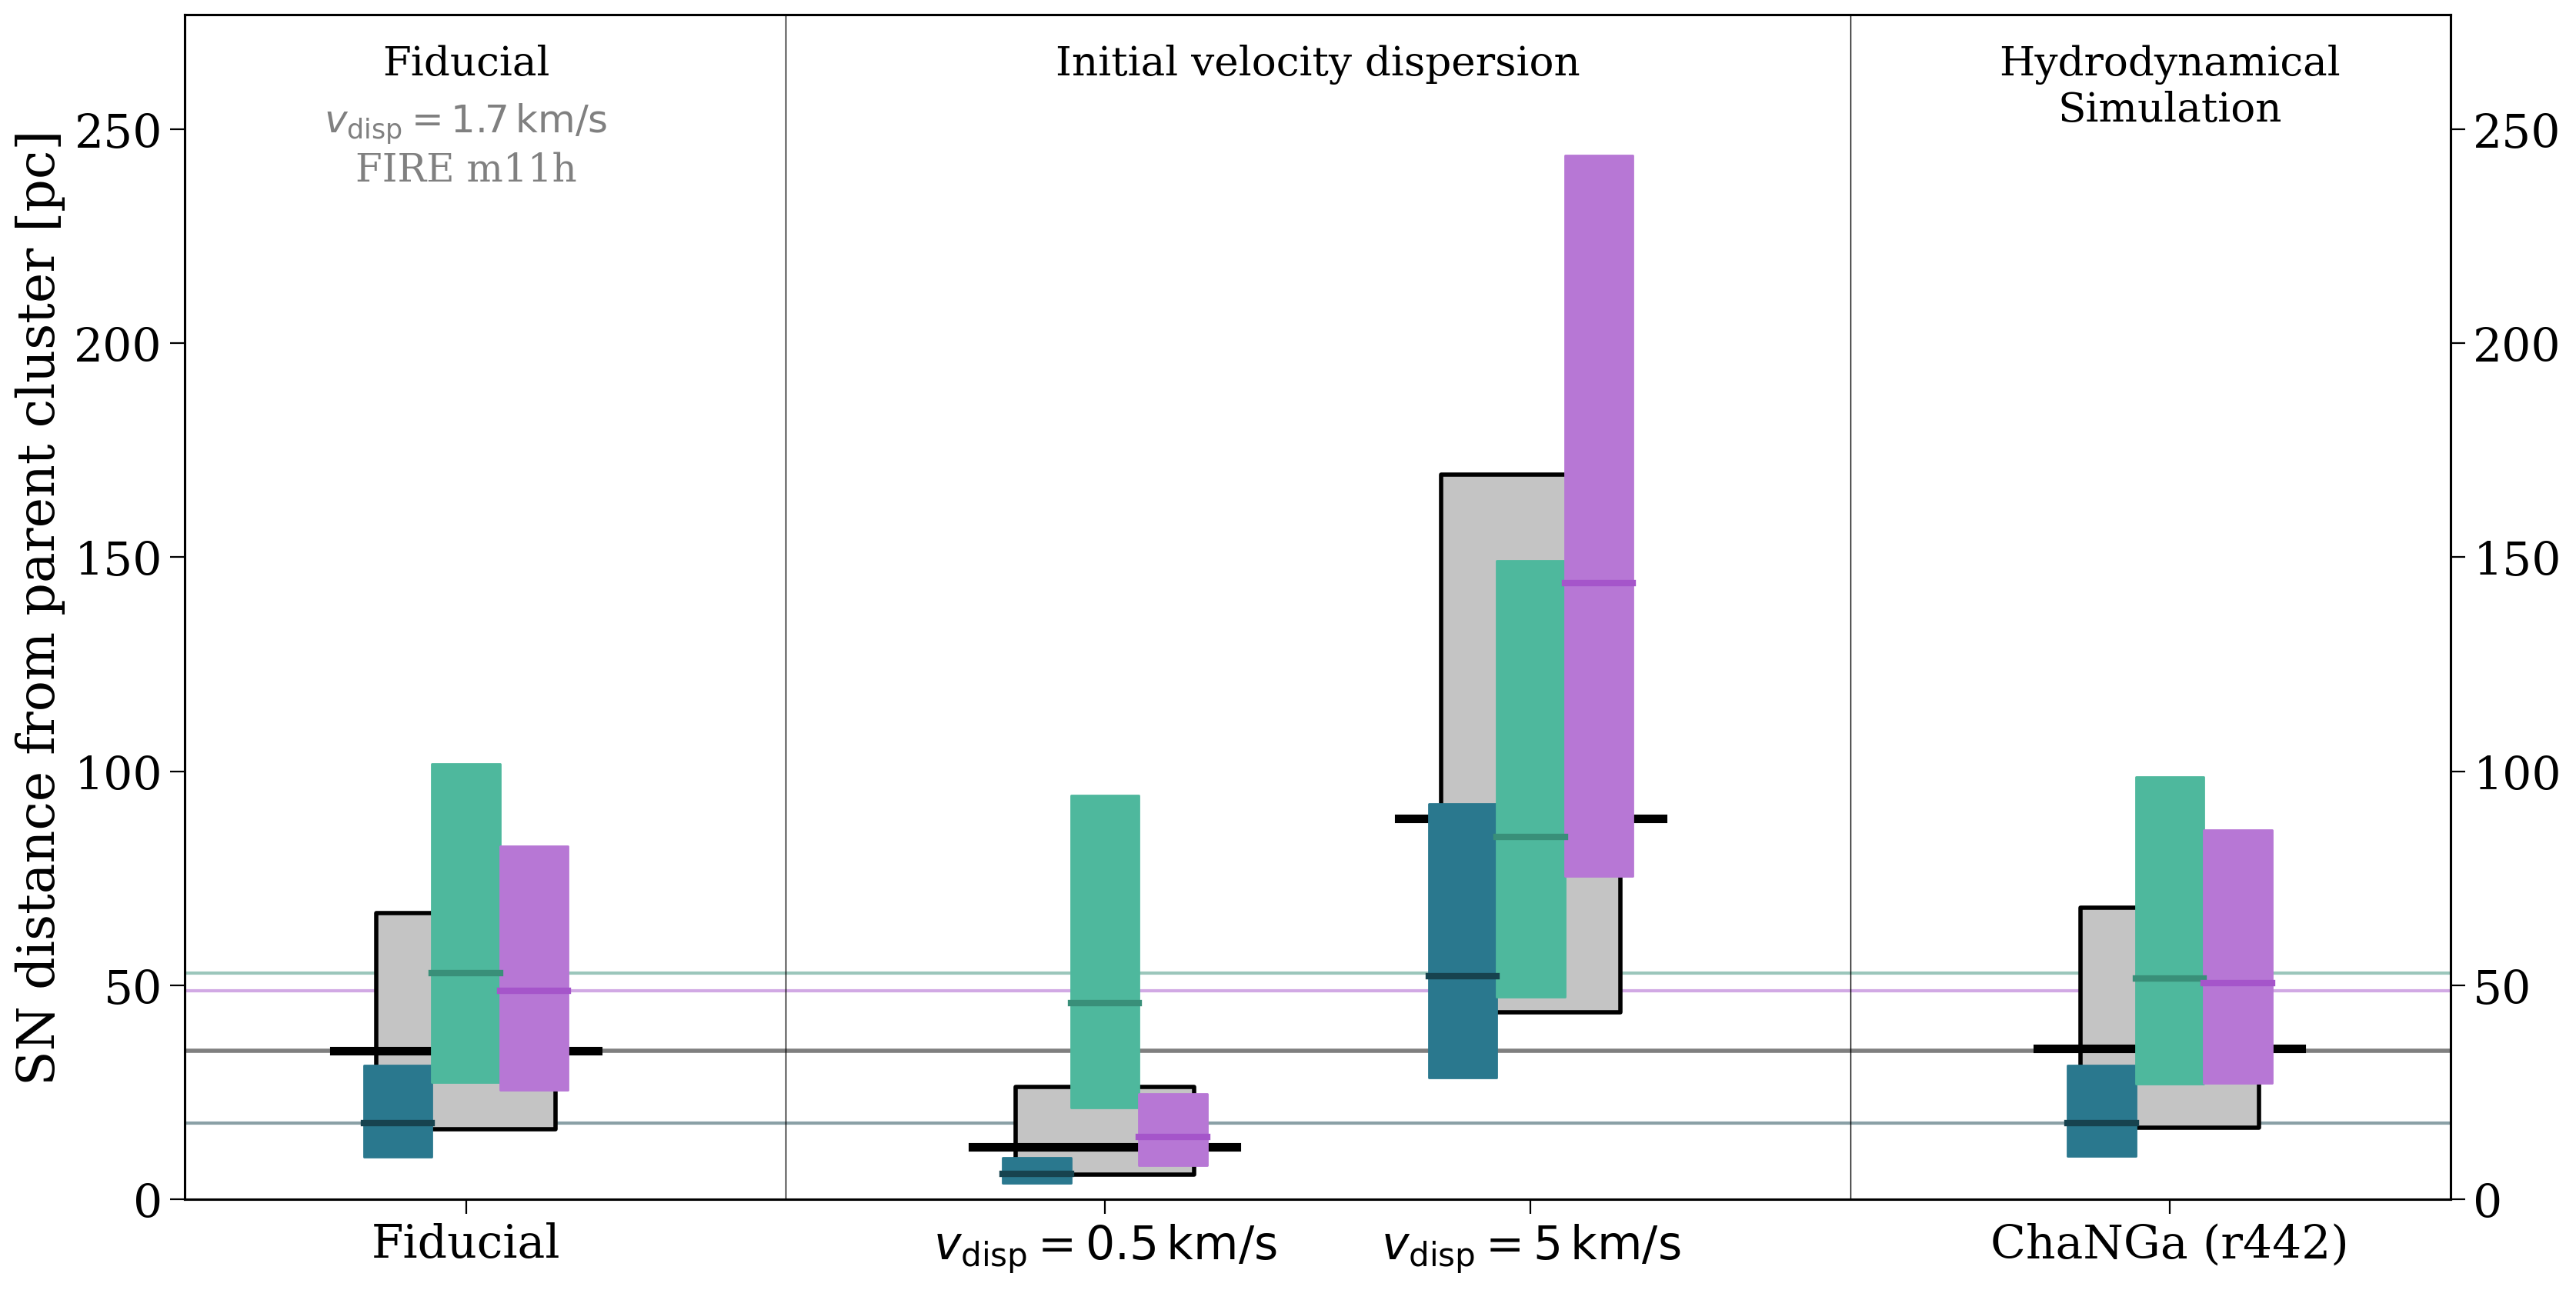

In [60]:
reload(plotting)

for f, plot in plot_settings.items():
    reload(plotting)
    fig, ax = plotting.compare_variations_from_stats(stats, **plot, quantity="time", annotate_loc=100,
                                                     show=False, show_labels=False)
    plt.savefig(f"../plots/variations/var-{f}-time.pdf", format="pdf", bbox_inches="tight")
    plt.show()
    
    reload(plotting)
    fig, ax = plotting.compare_variations_from_stats(stats, **plot, quantity="distance", annotate_loc=270,
                                                     show=False, show_rel_bars=False, show_legend=False)
    plt.savefig(f"../plots/variations/var-{f}-dist.pdf", format="pdf", bbox_inches="tight")
    plt.show()

# STUFF

In [1]:
from cosmic.sample.initialbinarytable import InitialBinaryTable
from cosmic.evolve import Evolve

single_binary = InitialBinaryTable.InitialBinaries(m1=20, m2=15, porb=100, ecc=0.0, tphysf=13700.0,
                                                   kstar1=1, kstar2=1, metallicity=0.02)

# bpp.to_hdf("../data/cosmic.h5", key="bpp")
# kick_info.to_hdf("../data/cosmic.h5", key="kick_info")


In [10]:
%%time
N = 50000
ibt = single_binary.loc[single_binary.index.repeat(N)].reset_index()
BSEDict = {'xi': 1.0, 'bhflag': 1, 'neta': 0.5, 'windflag': 3, 'wdflag': 1, 'alpha1': 1.0, 'pts1': 0.001, 'pts3': 0.02, 'pts2': 0.01, 'epsnov': 0.001, 'hewind': 0.5, 'ck': 1000, 'bwind': 0.0, 'lambdaf': 0.0, 'mxns': 3.0, 'beta': -1.0, 'tflag': 1, 'acc2': 1.5, 'grflag': 1, 'remnantflag': 4, 'ceflag': 0, 'eddfac': 1.0, 'ifflag': 0, 'bconst': 3000, 'sigma': 265, 'gamma': -2.0, 'pisn': 45.0, 'natal_kick_array': [[-100.0, -100.0, -100.0, -100.0, 0.0], [-100.0, -100.0, -100.0, -100.0, 0.0]], 'bhsigmafrac': 1.0, 'polar_kick_angle': 90, 'qcrit_array': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'cekickflag': 2, 'cehestarflag': 0, 'cemergeflag': 0, 'ecsn': 2.25, 'ecsn_mlow': 1.6, 'aic': 1, 'ussn': 0, 'sigmadiv': -20.0, 'qcflag': 5, 'eddlimflag': 0, 'fprimc_array': [0.09523809523809523, 0.09523809523809523, 0.09523809523809523, 0.09523809523809523, 0.09523809523809523, 0.09523809523809523, 0.09523809523809523, 0.09523809523809523, 0.09523809523809523, 0.09523809523809523, 0.09523809523809523, 0.09523809523809523, 0.09523809523809523, 0.09523809523809523, 0.09523809523809523, 0.09523809523809523], 'bhspinflag': 0, 'bhspinmag': 0.0, 'rejuv_fac': 1.0, 'rejuvflag': 0, 'htpmb': 1, 'ST_cr': 1, 'ST_tide': 1, 'bdecayfac': 1, 'rembar_massloss': 0.5,
           'kickflag': -1, 'zsun': 0.014, 'bhms_coll_flag': 0, 'don_lim': -1, 'acc_lim': -1, 'binfrac': 0.5, 'rtmsflag': 0, 'wd_mass_lim': 1}
bpp, bcm, ibt, kick_info = Evolve.evolve(initialbinarytable=ibt, BSEDict=BSEDict, nproc=2)

/mnt/home/twagg/miniconda3/envs/cogsworth/lib/python3.10/site-packages/cosmic/evolve.py:286: UserWarning: The value for binfrac in initial binary table is being overwritten by the value of binfrac from either the params file or the BSEDict.
  warnings.warn("The value for {0} in initial binary table is being "


CPU times: user 3.42 s, sys: 1.4 s, total: 4.81 s
Wall time: 13min 38s
